<a href="https://colab.research.google.com/github/iamdkshah/Data_Science_Project_23106359/blob/main/D_S_Project_23106359_(19).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up

In [ ]:
# Cell 1: Environment setup
from google.colab import drive
drive.mount('/content/drive')

# Install packages
!pip -q install xgboost optuna pvlib properscoring arch

# Imports
import os, warnings, random
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Stats / time-series
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, kpss

# ML
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor

# XGBoost / HPO
import xgboost as xgb
import optuna

# Deep learning (TF/Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, LSTM, GRU, Dropout, Bidirectional,
                                     Input, LayerNormalization, Attention, MultiHeadAttention)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Solar/metrics/extras
import pvlib
from scipy import stats
from scipy.optimize import minimize
from collections import defaultdict
import datetime as dt
from IPython.display import display

# Reproducibility & thread hygiene
SEED = 42
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
for var in ["OMP_NUM_THREADS","OPENBLAS_NUM_THREADS","MKL_NUM_THREADS","VECLIB_MAXIMUM_THREADS","NUMEXPR_NUM_THREADS"]:
    os.environ.setdefault(var, "1")

# Quick environment report
print("Environment versions:")
print(f"  pandas        {pd.__version__}")
print(f"  numpy         {np.__version__}")
print(f"  statsmodels   {sm.__version__}")
import sklearn; print(f"  scikit-learn  {sklearn.__version__}")
print(f"  xgboost       {xgb.__version__}")
print(f"  optuna        {optuna.__version__}")
print(f"  tensorflow    {tf.__version__}")
print(f"  pvlib         {pvlib.__version__}")

gpus = tf.config.list_physical_devices('GPU')
print("GPU available:", bool(gpus), ("-> " + gpus[0].name if gpus else ""))
print("All packages imported successfully!")


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.3/978.3 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 11.6 MB/s eta 0:00:00
Environment versions:
  pandas        2.2.2
  numpy         2.0.2
  statsmodels   0.14.5
  scikit-learn  1.6.1
  xgboost       3.0.4
  optuna        4.5.0
  tensorflow    2.19.0
  pvlib         0.13.0
GPU available: False 
All packages imported successfully!


## Loading Dataset


In [ ]:
# Cell 2: Data loading & basic checks
print("Loading Solar Irradiance Dataset...")

DATA_URL = "https://raw.githubusercontent.com/iamdkshah/Data_Science_Project_23106359/main/solar_data_2024.csv"
FALLBACK_PATH = "/content/drive/MyDrive/solar-forecasting/data/solar_data_2024.csv"

def standardize_cols(df):
    df = df.copy()
    df.columns = (df.columns.str.strip()
                            .str.replace(r"[^\w\s]+", "_", regex=True)
                            .str.replace(r"\s+", "_", regex=True)
                            .str.lower())
    return df

def infer_and_set_time_index(df):
    candidates = ["timestamp","datetime","date_time","time","ts"]
    dt_col = next((c for c in candidates if c in df.columns), None)
    if dt_col is None:
        raise ValueError("No datetime-like column found among: " + ", ".join(candidates))
    df[dt_col] = pd.to_datetime(df[dt_col], errors="coerce", utc=True)
    df = df.loc[df[dt_col].notna()].sort_values(dt_col)
    dup_count = int(df.duplicated(subset=[dt_col]).sum())
    df = df.drop_duplicates(subset=[dt_col], keep="first").set_index(dt_col)
    return df, dt_col, dup_count

try:
    df = pd.read_csv(DATA_URL, low_memory=False)
    print("Dataset loaded successfully from GitHub.")
except Exception as e:
    print(f"GitHub load failed: {e}")
    print("Attempting local fallback...")
    df = pd.read_csv(FALLBACK_PATH, low_memory=False)
    print("Dataset loaded from local fallback.")

df = standardize_cols(df)
df, dt_col, dup_removed = infer_and_set_time_index(df)

# Frequency & gaps
deltas = df.index.to_series().diff().dropna()
mode_delta = deltas.mode().iloc[0] if not deltas.empty else pd.NaT
adherence_30 = float((deltas == pd.Timedelta(minutes=30)).mean()) * 100 if len(deltas) else np.nan
gaps = int((deltas > mode_delta).sum()) if pd.notna(mode_delta) else 0

print("\nDATASET OVERVIEW")
print(f"Columns: {len(df.columns)} | Shape: {df.shape} | Mem: {df.memory_usage(deep=True).sum()/1024**2:.2f} MB")

print("\nTEMPORAL COVERAGE")
print(f"Datetime column: {dt_col}")
print(f"Start: {df.index.min()}  End: {df.index.max()}")
print(f"Mode step: {mode_delta}  |  30-min adherence: {adherence_30:.2f}%")
print(f"Duplicates removed: {dup_removed}  |  Gaps (>{mode_delta}): {gaps}")

print("\nCOLUMN NAMES")
print(df.columns.tolist())

print("\nFIRST 5 ROWS")
display(df.head(5))

print("\nDATA TYPES SUMMARY")
print(df.dtypes.value_counts())

targets = ["ghi","dni","dhi"]
print("\nTARGET VARIABLES STATUS")
for t in targets:
    print(f"{t.upper()}: {'Available' if t in df.columns else 'Missing'}")


Loading Solar Irradiance Dataset...
Dataset loaded successfully from GitHub.

DATASET OVERVIEW
Columns: 48 | Shape: (17568, 48) | Mem: 6.57 MB

TEMPORAL COVERAGE
Datetime column: timestamp
Start: 2024-01-01 00:00:00+00:00  End: 2024-12-31 23:30:00+00:00
Mode step: 0 days 00:30:00  |  30-min adherence: 100.00%
Duplicates removed: 0  |  Gaps (>0 days 00:30:00): 0

COLUMN NAMES
['year', 'jday', 'month', 'day', 'hour', 'minute', 'dt', 'solar_zenith', 'ghi', 'ghi_flag', 'uw_solar', 'uw_solar_flag', 'dni', 'dni_flag', 'dhi', 'dhi_flag', 'dw_ir', 'dw_ir_flag', 'dw_casetemp', 'dw_casetemp_flag', 'dw_dometemp', 'dw_dometemp_flag', 'uw_ir', 'uw_ir_flag', 'uw_casetemp', 'uw_casetemp_flag', 'uw_dometemp', 'uw_dometemp_flag', 'uvb', 'uvb_flag', 'par', 'par_flag', 'netsolar', 'netsolar_flag', 'netir', 'netir_flag', 'totalnet', 'totalnet_flag', 'temp_air', 'temp_air_flag', 'relative_humidity', 'relative_humidity_flag', 'wind_speed', 'wind_speed_flag', 'wind_direction', 'wind_direction_flag', 'pressur

,year,jday,month,day,hour,minute,dt,solar_zenith,ghi,ghi_flag,...,temp_air,temp_air_flag,relative_humidity,relative_humidity_flag,wind_speed,wind_speed_flag,wind_direction,wind_direction_flag,pressure,pressure_flag
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00+00:00,2024.0,1.0,1.0,1.0,0.0,14.5,0.241667,115.696333,-1.190000,0.0,...,0.206667,0.0,95.540000,0.0,1.136667,0.0,261.023333,0.0,970.856667,0.0
2024-01-01 00:30:00+00:00,2024.0,1.0,1.0,1.0,0.0,44.5,0.741667,121.334667,-1.033333,0.0,...,0.330000,0.0,94.596667,0.0,1.603333,0.0,238.030000,0.0,970.966667,0.0
2024-01-01 01:00:00+00:00,2024.0,1.0,1.0,1.0,1.0,14.5,1.241667,127.008000,-1.053333,0.0,...,0.376667,0.0,94.613333,0.0,1.716667,0.0,238.773333,0.0,970.910000,0.0
2024-01-01 01:30:00+00:00,2024.0,1.0,1.0,1.0,1.0,44.5,1.741667,132.679667,-1.133333,0.0,...,0.606667,0.0,93.256667,0.0,1.956667,0.0,218.713333,0.0,970.786667,0.0
2024-01-01 02:00:00+00:00,2024.0,1.0,1.0,1.0,2.0,14.5,2.241667,138.301000,-1.033333,0.0,...,0.706667,0.0,92.960000,0.0,2.103333,0.0,244.040000,0.0,970.743333,0.0



DATA TYPES SUMMARY
float64    48
Name: count, dtype: int64

TARGET VARIABLES STATUS
GHI: Available
DNI: Available
DHI: Available


Starting Exploratory Data Analysis...
BASIC DATASET STATISTICS
Rows x Cols: 17568 x 48
Index timezone: UTC
Start: 2024-01-01 00:00:00+00:00  End: 2024-12-31 23:30:00+00:00
Temporal span: 365 days 23:30:00

TEMPORAL CONSISTENCY
Mode step: 0 days 00:30:00  |  30-minute adherence: 100.00%
Duplicate timestamps: 0  |  Gaps (>mode step): 0

MISSING DATA (top 15)


,missing_count,missing_pct
dni,408,2.32
wind_speed,332,1.89
wind_direction,332,1.89
totalnet,284,1.62
uvb,232,1.32
netsolar,201,1.14
dhi,197,1.12
uw_solar,197,1.12
ghi,176,1.00
dw_ir,154,0.88



SOLAR VARIABLES AVAILABLE: ['ghi', 'dni', 'dhi', 'netsolar', 'totalnet']
Solar variables summary


,ghi,dni,dhi,netsolar,totalnet
count,17392.00,17160.00,17371.00,17367.00,17284.00
mean,161.09,157.55,70.43,126.44,77.29
std,253.14,290.28,105.62,200.85,178.37
min,-8.35,-2.07,-1.23,0.00,-100.87
25%,-1.14,-0.12,-0.09,0.00,-40.11
50%,3.91,0.10,4.68,3.83,-3.80
75%,242.34,146.66,110.60,184.76,131.03
max,1099.72,1020.49,688.28,895.00,796.24


Physical checks {negatives, zeros, >1300 W/m²}
ghi: {'negatives': 8224, 'zeros': 0, 'gt_1300': 0}
dni: {'negatives': 6641, 'zeros': 479, 'gt_1300': 0}
dhi: {'negatives': 5303, 'zeros': 657, 'gt_1300': 0}
netsolar: {'negatives': 0, 'zeros': 7727, 'gt_1300': 0}
totalnet: {'negatives': 9518, 'zeros': 131, 'gt_1300': 0}


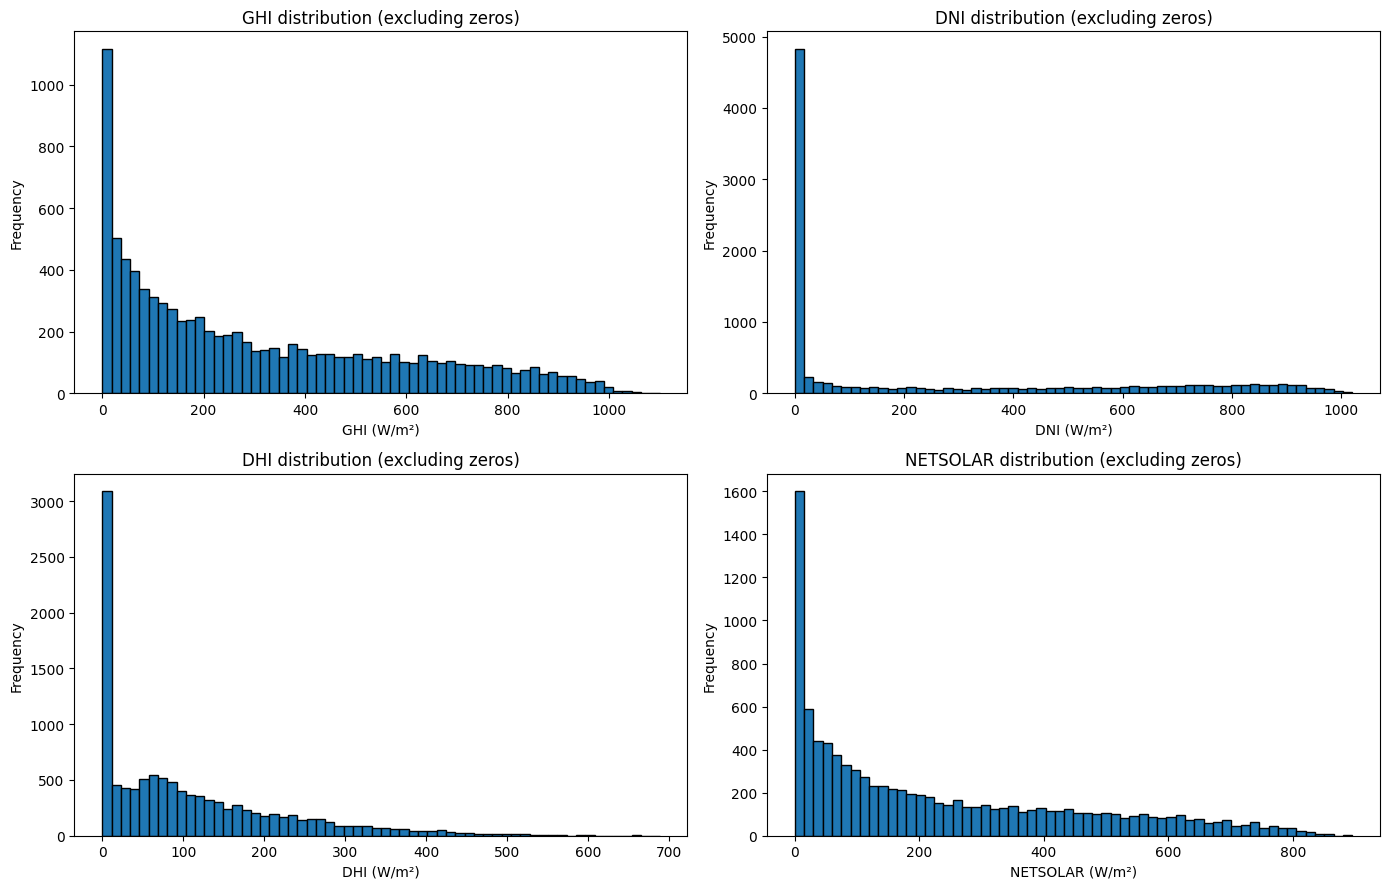


WEATHER VARIABLES AVAILABLE: ['temp_air', 'relative_humidity', 'wind_speed', 'pressure']
Weather variables summary


,temp_air,relative_humidity,wind_speed,pressure
count,17469.00,17469.00,17236.00,17473.00
mean,11.20,70.52,2.82,973.06
std,9.87,18.96,2.19,11.29
min,-18.41,15.37,0.00,303.44
25%,3.05,56.20,1.06,969.16
50%,11.29,73.75,2.35,973.14
75%,19.20,87.63,4.01,977.72
max,34.86,100.31,15.15,1000.71


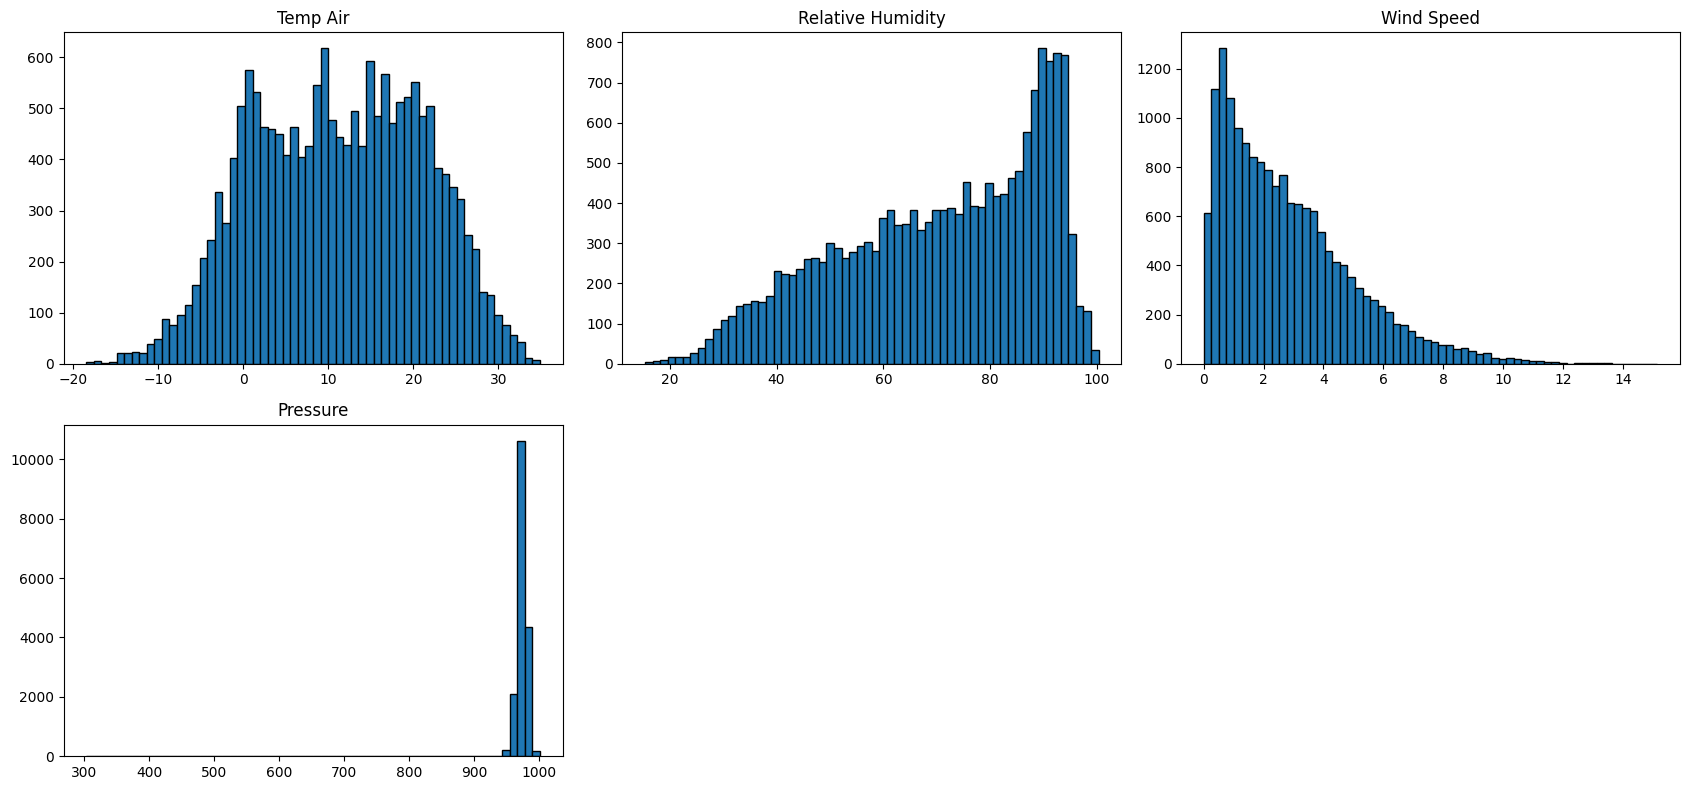


QUALITY FLAGS
Detected: 20
ghi_flag: unique=25  non_zero=463
uw_solar_flag: unique=7  non_zero=201
dni_flag: unique=32  non_zero=654
dhi_flag: unique=13  non_zero=226
dw_ir_flag: unique=11  non_zero=206
dw_casetemp_flag: unique=3  non_zero=73
dw_dometemp_flag: unique=3  non_zero=73
uw_ir_flag: unique=3  non_zero=73
uw_casetemp_flag: unique=3  non_zero=73
uw_dometemp_flag: unique=3  non_zero=73


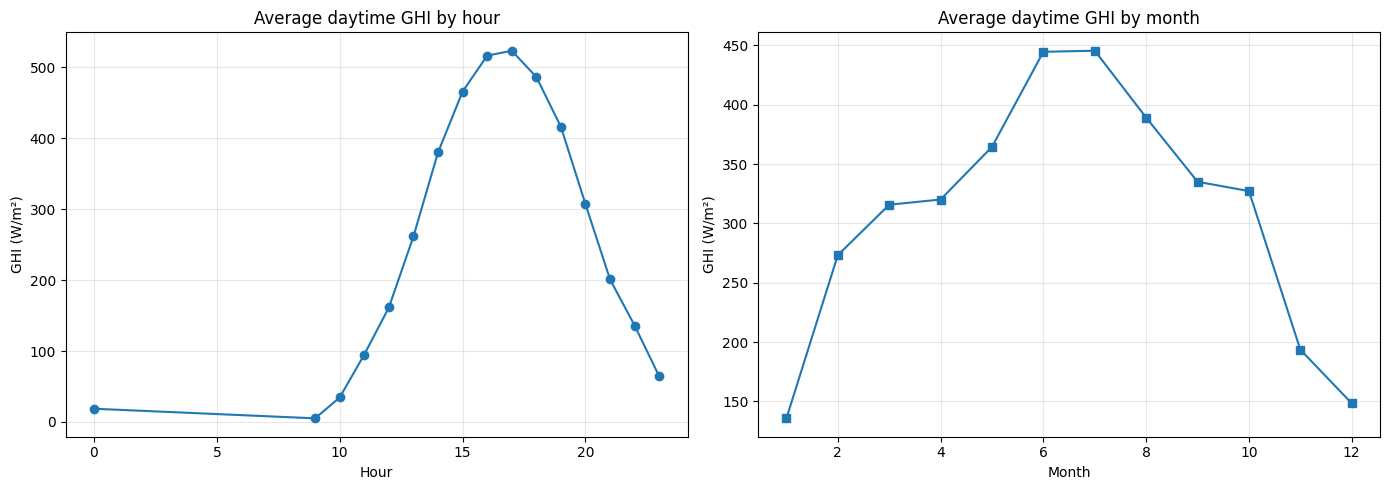

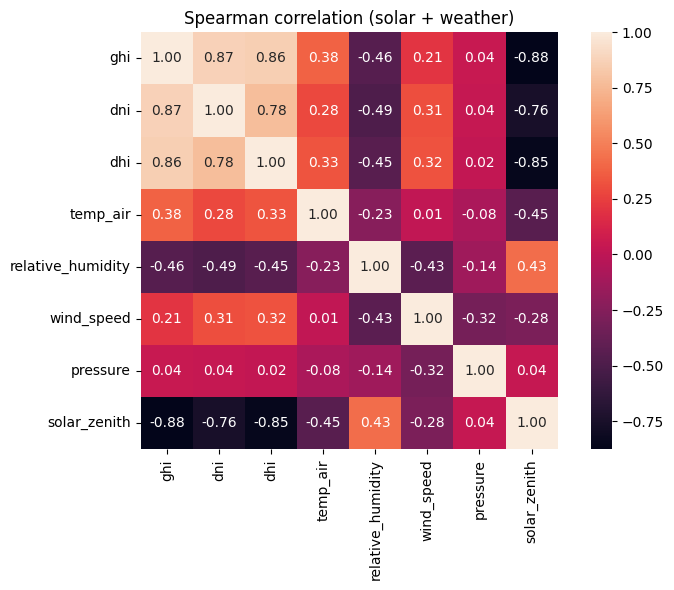


DATA QUALITY SUMMARY
rows: 17568
cols: 48
tz: UTC
start: 2024-01-01 00:00:00+00:00
end: 2024-12-31 23:30:00+00:00
mode_step: 0 days 00:30:00
adherence_30min_pct: 100.0
duplicates: 0
gaps_gt_mode: 0
missing_cols: 48
targets_available: 3

Exploratory Data Analysis complete.


In [ ]:
# Cell 3: Exploratory Data Analysis (EDA) & Data Quality Assessment
print("Starting Exploratory Data Analysis...")

assert isinstance(df.index, pd.DatetimeIndex), "df must be indexed by a DatetimeIndex."
assert df.index.is_monotonic_increasing, "Index should be sorted chronologically."
tzinfo = str(df.index.tz) if getattr(df.index, "tz", None) is not None else "naive"

print("BASIC DATASET STATISTICS")
print(f"Rows x Cols: {df.shape[0]} x {df.shape[1]}")
print(f"Index timezone: {tzinfo}")
print(f"Start: {df.index.min()}  End: {df.index.max()}")
print(f"Temporal span: {df.index.max() - df.index.min()}")

# Temporal consistency
deltas = df.index.to_series().diff().dropna()
mode_delta = deltas.mode().iloc[0] if not deltas.empty else pd.NaT
adherence_30 = (deltas == pd.Timedelta(minutes=30)).mean() * 100 if len(deltas) else np.nan
dup_count = int(df.index.duplicated(keep="first").sum())
gap_count = int((deltas > mode_delta).sum()) if pd.notna(mode_delta) else 0
print("\nTEMPORAL CONSISTENCY")
print(f"Mode step: {mode_delta}  |  30-minute adherence: {adherence_30:.2f}%")
print(f"Duplicate timestamps: {dup_count}  |  Gaps (>mode step): {gap_count}")

# Missing data
missing_cnt = df.isna().sum()
missing_pct = (missing_cnt / len(df) * 100).round(2)
missing_summary = (pd.DataFrame({"missing_count": missing_cnt, "missing_pct": missing_pct})
                   .sort_values("missing_pct", ascending=False))
print("\nMISSING DATA (top 15)")
display(missing_summary.head(15))

# Solar variables
solar_vars = ["ghi", "dni", "dhi", "netsolar", "totalnet"]
solar_avail = [c for c in solar_vars if c in df.columns]
print("\nSOLAR VARIABLES AVAILABLE:", solar_avail)

if solar_avail:
    print("Solar variables summary")
    display(df[solar_avail].describe().round(2))

    # physics checks
    phys_summary = {}
    for t in solar_avail:
        s = pd.to_numeric(df[t], errors="coerce")
        phys_summary[t] = {"negatives": int((s < 0).sum()),
                           "zeros": int((s == 0).sum()),
                           "gt_1300": int((s > 1300).sum())}
    print("Physical checks {negatives, zeros, >1300 W/m²}")
    for k, v in phys_summary.items():
        print(f"{k}: {v}")

    # distributions
    to_plot = solar_avail[:4]
    if to_plot:
        fig, axes = plt.subplots(2, 2, figsize=(14, 9))
        axes = axes.flatten()
        for i, col in enumerate(to_plot):
            data = pd.to_numeric(df[col], errors="coerce")
            data = data[data > 0]
            if len(data) > 0:
                axes[i].hist(data.dropna(), bins=60, edgecolor="black")
                axes[i].set_title(f"{col.upper()} distribution (excluding zeros)")
                axes[i].set_xlabel(f"{col.upper()} (W/m²)")
                axes[i].set_ylabel("Frequency")
            else:
                axes[i].text(0.5, 0.5, f"{col}: no positive values", ha="center", va="center")
                axes[i].set_axis_off()
        for j in range(len(to_plot), len(axes)):
            axes[j].set_axis_off()
        plt.tight_layout(); plt.show()

# Weather variables
weather_vars = ["temp_air", "relative_humidity", "wind_speed", "pressure"]
weather_avail = [c for c in weather_vars if c in df.columns]
print("\nWEATHER VARIABLES AVAILABLE:", weather_avail)

if weather_avail:
    print("Weather variables summary")
    display(df[weather_avail].describe().round(2))

    n = len(weather_avail)
    if n:
        rows, cols = 2, min(3, n)
        fig, axes = plt.subplots(rows, cols, figsize=(17, 8))
        axes = np.array(axes).reshape(rows, cols)
        for i, col in enumerate(weather_avail):
            r, c = divmod(i, cols)
            ax = axes[r, c]
            ax.hist(pd.to_numeric(df[col], errors="coerce").dropna(), bins=60, edgecolor="black")
            ax.set_title(col.replace("_"," ").title())
        for k in range(n, rows*cols):
            r, c = divmod(k, cols)
            axes[r, c].set_axis_off()
        plt.tight_layout(); plt.show()

# Flags
flag_cols = [c for c in df.columns if c.endswith("_flag")]
print("\nQUALITY FLAGS")
print(f"Detected: {len(flag_cols)}")
if flag_cols:
    top_show = flag_cols[:10]
    for fc in top_show:
        counts = df[fc].value_counts(dropna=False).sort_index()
        non_zero = int((df[fc] != 0).sum())
        print(f"{fc}: unique={len(counts)}  non_zero={non_zero}")

# Daytime patterns
if "ghi" in df.columns:
    tmp = pd.DataFrame(index=df.index)
    tmp["ghi"] = pd.to_numeric(df["ghi"], errors="coerce")
    if "solar_zenith" in df.columns:
        tmp["is_day"] = df["solar_zenith"] <= 90
    else:
        tmp["is_day"] = tmp["ghi"] > 0

    tmp["hour"] = tmp.index.hour
    tmp["month"] = tmp.index.month

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    hourly = tmp.loc[tmp["is_day"], :].groupby("hour")["ghi"].mean()
    plt.plot(hourly.index, hourly.values, marker="o"); plt.title("Average daytime GHI by hour"); plt.grid(alpha=0.3)
    plt.xlabel("Hour"); plt.ylabel("GHI (W/m²)")

    plt.subplot(1, 2, 2)
    monthly = tmp.loc[tmp["is_day"], :].groupby("month")["ghi"].mean()
    plt.plot(monthly.index, monthly.values, marker="s"); plt.title("Average daytime GHI by month"); plt.grid(alpha=0.3)
    plt.xlabel("Month"); plt.ylabel("GHI (W/m²)")
    plt.tight_layout(); plt.show()

# Correlations
corr_cols = [c for c in ["ghi", "dni", "dhi", "temp_air", "relative_humidity",
                         "wind_speed", "pressure", "solar_zenith"] if c in df.columns]
if len(corr_cols) >= 3:
    corr_df = df[corr_cols].apply(pd.to_numeric, errors="coerce")
    corr = corr_df.corr(method="spearman")
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, fmt=".2f", square=True, cbar=True)
    plt.title("Spearman correlation (solar + weather)")
    plt.tight_layout(); plt.show()

quality_report = {
    "rows": len(df), "cols": len(df.columns), "tz": tzinfo,
    "start": str(df.index.min()), "end": str(df.index.max()),
    "mode_step": str(mode_delta),
    "adherence_30min_pct": None if np.isnan(adherence_30) else round(adherence_30, 2),
    "duplicates": dup_count, "gaps_gt_mode": gap_count,
    "missing_cols": int((missing_cnt > 0).sum()),
    "targets_available": int(sum(c in df.columns for c in ["ghi","dni","dhi"])),
}
print("\nDATA QUALITY SUMMARY")
for k, v in quality_report.items():
    print(f"{k}: {v}")

print("\nExploratory Data Analysis complete.")


In [ ]:
# Cell 4 — Data preprocessing (fast, leakage-safe)
print("Starting Data Preprocessing")

base = df.copy()
df_work = base.copy()

# 1) Ensure DatetimeIndex (already set in Cell 2, but keep guard)
if not isinstance(df_work.index, pd.DatetimeIndex):
    raise ValueError("Dataframe must be indexed by DatetimeIndex after Cell 2.")
df_work.index = df_work.index.tz_convert("UTC") if df_work.index.tz is not None else df_work.index.tz_localize("UTC")
df_work.index.name = 'timestamp'

# 2) Useful columns
solar_cols   = [c for c in ['ghi','dni','dhi','solar_zenith'] if c in df_work.columns]
weather_cols = [c for c in ['temp_air','relative_humidity','wind_speed','pressure'] if c in df_work.columns]

# 3) Day/night mask
if 'solar_zenith' in df_work.columns:
    df_work['is_day'] = (pd.to_numeric(df_work['solar_zenith'], errors='coerce') <= 90).astype(int)
else:
    # coarse fallback
    df_work['is_day'] = (pd.to_numeric(df_work.get('ghi', pd.Series(index=df_work.index, dtype=float)), errors='coerce') > 0).astype(int)

# 4) Missing summary before
key_vars = ['ghi','dni','dhi','temp_air','relative_humidity','wind_speed','pressure']
miss_before = {k:int(pd.to_numeric(df_work[k], errors="coerce").isna().sum()) for k in key_vars if k in df_work.columns}
print("Missing before:", miss_before)

# 5) Clamp negatives & outliers with physics-aware rules
night_mask = df_work['is_day'] == 0
for v, upper in [('ghi',1400), ('dni',1200), ('dhi',800)]:
    if v in df_work.columns:
        s = pd.to_numeric(df_work[v], errors="coerce")
        # night: negatives -> 0; keep zeros
        s.loc[night_mask] = np.maximum(s.loc[night_mask], 0.0)
        # day: small negatives -> 0
        day_mask = ~night_mask
        s.loc[day_mask & (s < 0) & (s > -10)] = 0.0
        df_work[v] = s.clip(lower=0, upper=upper)

# 6) Impute missing values
# solar: time interpolation (<= 3 hours), ok pre-split since it's physical continuity
for v in ['ghi','dni','dhi']:
    if v in df_work.columns:
        df_work[v] = pd.to_numeric(df_work[v], errors="coerce")
        df_work[v] = df_work[v].interpolate(method='time', limit=6)

# weather: short ffill/bfill then linear (bounded)
for v in ['temp_air','relative_humidity','wind_speed','pressure']:
    if v in df_work.columns:
        s = pd.to_numeric(df_work[v], errors="coerce")
        s = s.ffill(limit=4).bfill(limit=4).interpolate(limit=12)
        if v == 'relative_humidity': s = s.clip(0, 100)
        if v == 'wind_speed':        s = s.clip(lower=0)
        if v == 'temp_air':          s = s.clip(-50, 60)
        if v == 'pressure':          s = s.clip(800, 1100)
        df_work[v] = s

# 7) Final numeric coercion (keeps names; helps later dtypes)
for c in solar_cols + weather_cols:
    if c in df_work.columns:
        df_work[c] = pd.to_numeric(df_work[c], errors="coerce")

# 8) Missing summary after
miss_after = {k:int(df_work[k].isna().sum()) for k in key_vars if k in df_work.columns}
print("Missing after:", miss_after)

# 9) Final clean frames
df_clean = df_work.copy()
df_model = df_clean[['ghi']
                    + [c for c in ['dni','dhi','solar_zenith'] if c in df_clean.columns]
                    + [c for c in ['temp_air','relative_humidity','wind_speed','pressure'] if c in df_clean.columns]
                    + ['is_day']].copy()

print(f"Total rows: {len(df_clean)}, Total columns: {df_clean.shape[1]}")
display(df_clean.head(10))


Starting Data Preprocessing
Missing before: {'ghi': 176, 'dni': 408, 'dhi': 197, 'temp_air': 99, 'relative_humidity': 99, 'wind_speed': 332, 'pressure': 95}
Missing after: {'ghi': 126, 'dni': 188, 'dhi': 188, 'temp_air': 75, 'relative_humidity': 75, 'wind_speed': 59, 'pressure': 52}
Total rows: 17568, Total columns: 49


,year,jday,month,day,hour,minute,dt,solar_zenith,ghi,ghi_flag,...,temp_air_flag,relative_humidity,relative_humidity_flag,wind_speed,wind_speed_flag,wind_direction,wind_direction_flag,pressure,pressure_flag,is_day
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00+00:00,2024.0,1.0,1.0,1.0,0.0,14.5,0.241667,115.696333,0.0,0.0,...,0.0,95.540000,0.0,1.136667,0.0,261.023333,0.0,970.856667,0.0,0
2024-01-01 00:30:00+00:00,2024.0,1.0,1.0,1.0,0.0,44.5,0.741667,121.334667,0.0,0.0,...,0.0,94.596667,0.0,1.603333,0.0,238.030000,0.0,970.966667,0.0,0
2024-01-01 01:00:00+00:00,2024.0,1.0,1.0,1.0,1.0,14.5,1.241667,127.008000,0.0,0.0,...,0.0,94.613333,0.0,1.716667,0.0,238.773333,0.0,970.910000,0.0,0
2024-01-01 01:30:00+00:00,2024.0,1.0,1.0,1.0,1.0,44.5,1.741667,132.679667,0.0,0.0,...,0.0,93.256667,0.0,1.956667,0.0,218.713333,0.0,970.786667,0.0,0
2024-01-01 02:00:00+00:00,2024.0,1.0,1.0,1.0,2.0,14.5,2.241667,138.301000,0.0,0.0,...,0.0,92.960000,0.0,2.103333,0.0,244.040000,0.0,970.743333,0.0,0
2024-01-01 02:30:00+00:00,2024.0,1.0,1.0,1.0,2.0,44.5,2.741667,143.802000,0.0,0.0,...,0.0,92.460000,0.0,2.390000,0.0,242.276667,0.0,970.666667,0.0,0
2024-01-01 03:00:00+00:00,2024.0,1.0,1.0,1.0,3.0,14.5,3.241667,149.079000,0.0,0.0,...,0.0,93.123333,0.0,2.283333,0.0,246.016667,0.0,970.510000,0.0,0
2024-01-01 03:30:00+00:00,2024.0,1.0,1.0,1.0,3.0,44.5,3.741667,153.954000,0.0,0.0,...,0.0,93.413333,0.0,1.750000,0.0,248.586667,0.0,970.416667,0.0,0
2024-01-01 04:00:00+00:00,2024.0,1.0,1.0,1.0,4.0,14.5,4.241667,158.123333,0.0,0.0,...,0.0,93.866667,0.0,1.440000,0.0,248.263333,0.0,970.386667,0.0,0


In [ ]:
# Cell 5 — Feature engineering ( 1-hour horizon)

import numpy as np
import pandas as pd

print("Starting Feature Engineering for 1-hour ahead")

if "df_clean" not in globals():
    raise RuntimeError("df_clean not found. Run preprocessing first.")

df_features = df_clean.copy()
if not isinstance(df_features.index, pd.DatetimeIndex):
    raise TypeError("df_clean must have a DatetimeIndex.")

# --- detect cadence and set 1-hour horizon in steps ---
deltas = df_features.index.to_series().diff().dropna()
step = deltas.mode().iloc[0] if not deltas.empty else pd.Timedelta(minutes=30)
H_STEPS = int(round(pd.Timedelta(hours=1) / step))
if H_STEPS < 1: H_STEPS = 1
print(f"Detected step: {step}, using H_STEPS={H_STEPS} for 1-hour ahead")

# Calendar features
df_features["hour"]        = df_features.index.hour
df_features["weekday"]     = df_features.index.weekday
df_features["is_weekend"]  = (df_features["weekday"] >= 5).astype(int)
df_features["day_of_year"] = df_features.index.dayofyear

# Cyclical encodings
df_features["hour_sin"] = np.sin(2*np.pi*df_features["hour"]/24)
df_features["hour_cos"] = np.cos(2*np.pi*df_features["hour"]/24)
df_features["day_sin"]  = np.sin(2*np.pi*df_features["day_of_year"]/365)
df_features["day_cos"]  = np.cos(2*np.pi*df_features["day_of_year"]/365)

# Solar geometry derived
if "solar_zenith" in df_features.columns:
    z = df_features["solar_zenith"].astype(float)
    df_features["cos_zenith"]      = np.cos(np.radians(z)).clip(0, 1)
    df_features["solar_elevation"] = (90 - z).clip(lower=-90, upper=90)
else:
    df_features["cos_zenith"] = 0.0
    df_features["solar_elevation"] = 0.0

# Lag/rolling helpers
def add_lags(frame: pd.DataFrame, col: str, lags: list[int]) -> None:
    if col not in frame.columns: return
    for L in lags:
        frame[f"{col}_lag{L}"] = frame[col].shift(L)

def add_rolling(frame: pd.DataFrame, col: str, windows: list[int]) -> None:
    if col not in frame.columns: return
    for W in windows:
        mp = max(2, W // 2)
        frame[f"{col}_roll{W}_mean"] = frame[col].rolling(W, min_periods=mp).mean()
        frame[f"{col}_roll{W}_std"]  = frame[col].rolling(W, min_periods=mp).std()

# Horizon-aware lag/rolling sets
LAG_SET = sorted(set([1, H_STEPS, 2*H_STEPS, 4*H_STEPS, 12]))  # keep a medium lag too
ROLL_SET = sorted(set([H_STEPS, 2*H_STEPS, 4*H_STEPS, 12]))

# GHI lags & rolls
add_lags(df_features, "ghi", LAG_SET)
add_rolling(df_features, "ghi", ROLL_SET)

# Light weather lags
for w in ["temp_air", "relative_humidity", "wind_speed", "pressure"]:
    if w in df_features.columns:
        df_features[f"{w}_lag1"] = df_features[w].shift(1)
        df_features[f"{w}_lag{H_STEPS}"] = df_features[w].shift(H_STEPS)

# Build target for 1-hour ahead
TARGET_COL = f"target_ghi_t+{H_STEPS}"
if "ghi" not in df_features.columns:
    raise KeyError("Column 'ghi' not found for target creation.")
df_features[TARGET_COL] = df_features["ghi"].shift(-H_STEPS)

# Feature list
EXOG_BASE = [c for c in ["hour_sin","hour_cos","day_sin","day_cos","cos_zenith","weekday","is_weekend"]
             if c in df_features.columns]

LIGHT_ML_FEATS = (
    EXOG_BASE
    + [c for c in df_features.columns if c.startswith("ghi_lag")]
    + [c for c in df_features.columns if c.startswith("ghi_roll")]
    + [c for c in df_features.columns if c.endswith(f"_lag1") or c.endswith(f"_lag{H_STEPS}")]
)

FEATURE_COLS = sorted(list(dict.fromkeys(LIGHT_ML_FEATS)))

print("Features and target ready for 1-hour ahead")
print(f"Total columns in df_features: {df_features.shape[1]}")
print(f"Number of feature columns:   {len(FEATURE_COLS)}")
print("Sample features:", FEATURE_COLS[:10])
print("Target column:", TARGET_COL)

try:
    display(df_features[FEATURE_COLS + [TARGET_COL]].head(5))
except Exception:
    print(df_features[FEATURE_COLS + [TARGET_COL]].head(5))

# save shared config so later cells can pick it up
ML_DATA = ML_DATA if "ML_DATA" in globals() else {}
ML_DATA.update({"FEATS": FEATURE_COLS, "TARGET_COL": TARGET_COL, "H_STEPS": H_STEPS})


Starting Feature Engineering for 1-hour ahead
Detected step: 0 days 00:30:00, using H_STEPS=2 for 1-hour ahead
Features and target ready for 1-hour ahead
Total columns in df_features: 80
Number of feature columns:   28
Sample features: ['cos_zenith', 'day_cos', 'day_sin', 'ghi_lag1', 'ghi_lag12', 'ghi_lag2', 'ghi_lag4', 'ghi_lag8', 'ghi_roll12_mean', 'ghi_roll12_std']
Target column: target_ghi_t+2


,cos_zenith,day_cos,day_sin,ghi_lag1,ghi_lag12,ghi_lag2,ghi_lag4,ghi_lag8,ghi_roll12_mean,ghi_roll12_std,...,pressure_lag1,pressure_lag2,relative_humidity_lag1,relative_humidity_lag2,temp_air_lag1,temp_air_lag2,weekday,wind_speed_lag1,wind_speed_lag2,target_ghi_t+2
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00+00:00,0.0,0.999852,0.017213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0.0
2024-01-01 00:30:00+00:00,0.0,0.999852,0.017213,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,970.856667,NaN,95.540000,NaN,0.206667,NaN,0,1.136667,NaN,0.0
2024-01-01 01:00:00+00:00,0.0,0.999852,0.017213,0.0,NaN,0.0,NaN,NaN,NaN,NaN,...,970.966667,970.856667,94.596667,95.540000,0.330000,0.206667,0,1.603333,1.136667,0.0
2024-01-01 01:30:00+00:00,0.0,0.999852,0.017213,0.0,NaN,0.0,NaN,NaN,NaN,NaN,...,970.910000,970.966667,94.613333,94.596667,0.376667,0.330000,0,1.716667,1.603333,0.0
2024-01-01 02:00:00+00:00,0.0,0.999852,0.017213,0.0,NaN,0.0,0.0,NaN,NaN,NaN,...,970.786667,970.910000,93.256667,94.613333,0.606667,0.376667,0,1.956667,1.716667,0.0


In [ ]:
# Cell 6 — Time split, leakage-safe scaling for 1-hour ahead

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

print("Preparing modeling splits for 1-hour ahead")

FEATURE_COLS = ML_DATA["FEATS"]
target_col   = ML_DATA["TARGET_COL"]

# keep rows with full features and target
model_idx = df_features.dropna(subset=FEATURE_COLS + [target_col]).index
df_modeling = df_features.loc[model_idx, FEATURE_COLS + [target_col]].copy()

# chronological split 70/15/15
n = len(df_modeling)
i_train = int(0.70 * n)
i_val   = int(0.85 * n)

train_idx = df_modeling.index[:i_train]
val_idx   = df_modeling.index[i_train:i_val]
test_idx  = df_modeling.index[i_val:]

# scale features on train only
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(df_modeling.loc[train_idx, FEATURE_COLS].values)
X_val   = scaler_X.transform(df_modeling.loc[val_idx, FEATURE_COLS].values)
X_test  = scaler_X.transform(df_modeling.loc[test_idx, FEATURE_COLS].values)

y_train = df_modeling.loc[train_idx, target_col].values
y_val   = df_modeling.loc[val_idx, target_col].values
y_test  = df_modeling.loc[test_idx, target_col].values

ML_DATA.update({
    "X_train": X_train, "y_train": y_train,
    "X_val":   X_val,   "y_val":   y_val,
    "X_test":  X_test,  "y_test":  y_test,
    "index": {"train": train_idx, "val": val_idx, "test": test_idx},
    "scaler_X": scaler_X
})

print("Modeling frame:", len(df_modeling), "rows,", len(FEATURE_COLS), "features, target:", target_col)
print("Split sizes  train:", X_train.shape[0], " val:", X_val.shape[0], " test:", X_test.shape[0])


Preparing modeling splits for 1-hour ahead
Modeling frame: 17358 rows, 28 features, target: target_ghi_t+2
Split sizes  train: 12150  val: 2604  test: 2604


In [ ]:
# Cell 7 — Rolling CV (3 folds), persistence baseline for 1-hour ahead

import numpy as np
import pandas as pd

print("Building rolling CV and computing persistence baseline for 1-hour ahead")

H = ML_DATA["H_STEPS"]              # steps that equal 1 hour
target_col = ML_DATA["TARGET_COL"]

def rmse(a, b):
    return float(np.sqrt(np.mean((a - b)**2)))

def nrmse(a, b):
    m = max(np.mean(a), 1e-6)
    return rmse(a, b) / m

def day_mask_at_target(idx, h):
    if "is_day" not in df_features.columns:
        return np.ones(len(idx), dtype=bool)
    return df_features.loc[idx, 'is_day'].shift(-h).fillna(False).to_numpy().astype(bool)

# Persistence baseline on test: y_hat = y_t for t+1h
idx_test = ML_DATA["index"]["test"]
y_true_all = df_features.loc[idx_test, target_col].to_numpy()
y_now_all  = df_model.loc[idx_test, 'ghi'].to_numpy()
y_persist_all = y_now_all.copy()

mask_day = day_mask_at_target(idx_test, H)

mae_all = np.mean(np.abs(y_true_all - y_persist_all))
rmse_all = rmse(y_true_all, y_persist_all)
nrmse_all = nrmse(y_true_all, y_persist_all)

mae_day = np.mean(np.abs(y_true_all[mask_day] - y_persist_all[mask_day])) if mask_day.any() else np.nan
rmse_day = rmse(y_true_all[mask_day], y_persist_all[mask_day]) if mask_day.any() else np.nan
nrmse_day = nrmse(y_true_all[mask_day], y_persist_all[mask_day]) if mask_day.any() else np.nan

# Directional accuracy relative to y_t
true_dir = np.sign(y_true_all - y_now_all)
pred_dir = np.sign(y_persist_all - y_now_all)   # mostly zeros for persistence
dir_acc = np.mean((true_dir == pred_dir).astype(float))

print("Persistence baseline on test (t+1h)")
print(f"ALL  : MAE={mae_all:.2f}, RMSE={rmse_all:.2f}, nRMSE={nrmse_all:.3f}")
print(f"DAY  : MAE={mae_day:.2f}, RMSE={rmse_day:.2f}, nRMSE={nrmse_day:.3f}")
print(f"Directional accuracy: {dir_acc:.3f}")

# Rolling expanding CV folds (3 folds, small gap) on all rows
all_idx = df_features.index.dropna()
n = len(all_idx)
folds = []
n_test = 1000
n_gap = 100
for k in range(3):
    end_test = n - k * n_test
    start_test = max(end_test - n_test, 0)
    end_train = max(start_test - n_gap, 0)
    if end_train < 5000:
        break
    folds.append({
        "train_slice": slice(0, end_train),
        "val_slice": slice(end_train, start_test),
        "test_slice": slice(start_test, end_test)
    })

print(f"Constructed {len(folds)} CV folds")
for i, f in enumerate(folds, 1):
    tr = f["train_slice"]; va = f["val_slice"]; te = f["test_slice"]
    print(f"Fold {i}: train={tr.stop - tr.start}, val={va.stop - va.start}, test={te.stop - te.start}")


Building rolling CV and computing persistence baseline for 1-hour ahead
Persistence baseline on test (t+1h)
ALL  : MAE=27.23, RMSE=55.36, nRMSE=0.896
DAY  : MAE=65.75, RMSE=87.09, nRMSE=0.557
Directional accuracy: 0.537
Constructed 3 CV folds
Fold 1: train=16468, val=100, test=1000
Fold 2: train=15468, val=100, test=1000
Fold 3: train=14468, val=100, test=1000


## SARIMA MODEL

[DEV] 7673 rows | [TEST] 1029 rows | exog: 10

Chosen config by DEV RMSE: pdq=(2, 0, 1) seasonal=(1, 0, 1, 48) mode=residual
Fold RMSE: 133.9, 105.9, 93.5

SARIMAX (tiny-grid) — Test (day-only)
ALL_MAE: 64.4848
ALL_RMSE: 81.4496
ALL_R2: 0.6680
DIR_ACC (all day): 0.684  |  Dir. accuracy (|Δ|≥25): 0.707
Train time: 1851.37s | Inference time (test): 0.43s
Skill vs persistence (DAY): 6.5%


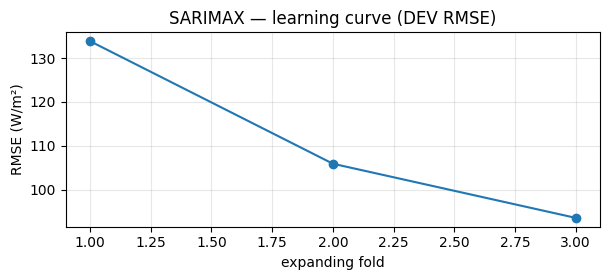

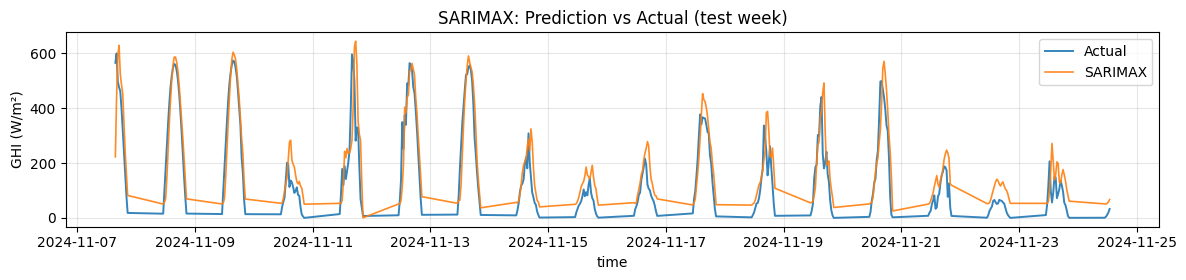

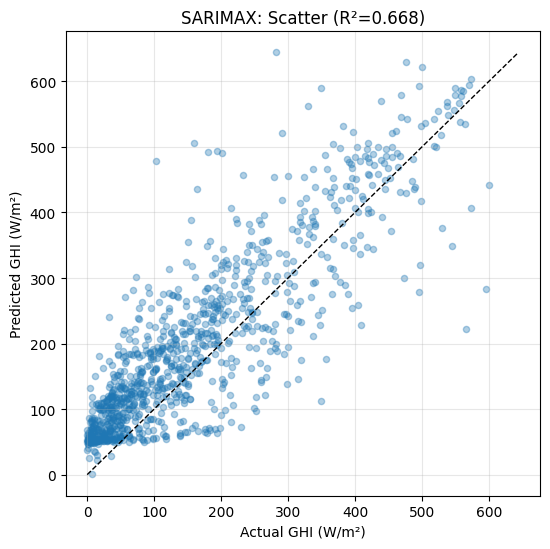

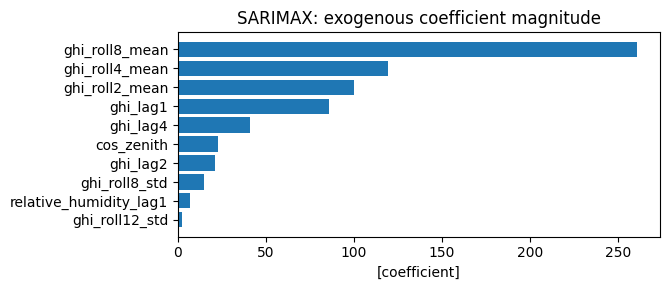


Saved: ML_DATA['models']['SARIMAX_benchmark'].


In [ ]:
# Cell S — SARIMAX
import time, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

FEATS      = ML_DATA["FEATS"]
TARGET_COL = ML_DATA["TARGET_COL"]
H          = int(ML_DATA["H_STEPS"])
MOVE_THRESH = 25.0

def day_mask_at_target(idx, h=H):
    if "is_day" not in df_features.columns:
        return np.ones(len(idx), dtype=bool)
    return df_features.loc[idx, "is_day"].shift(-h).fillna(False).to_numpy().astype(bool)

def rmse(a, b): a=np.asarray(a,float); b=np.asarray(b,float); return float(np.sqrt(np.mean((a-b)**2)))

def pick_top_exog(dev_df, feat_cols, target_col, k=10):
    y = pd.to_numeric(dev_df[target_col], errors="coerce")
    pairs = []
    for c in feat_cols:
        x = pd.to_numeric(dev_df[c], errors="coerce")
        m = x.notna() & y.notna()
        if m.sum() < 100:
            continue
        r = np.corrcoef(x[m], y[m])[0,1]
        if np.isfinite(r): pairs.append((c, abs(float(r))))
    pairs.sort(key=lambda t: t[1], reverse=True)
    return [c for c,_ in pairs[:k]]

# ---- DEV/TEST (day-only)
dev_index_full = ML_DATA["index"]["train"].union(ML_DATA["index"]["val"])
dev_index_day  = dev_index_full[day_mask_at_target(dev_index_full)]
test_index     = ML_DATA["index"]["test"]
test_index_day = test_index[day_mask_at_target(test_index)]

dev_df  = df_features.loc[dev_index_day, [TARGET_COL] + FEATS].copy()
test_df = df_features.loc[test_index_day, [TARGET_COL] + FEATS].copy()
dev_df["y_now"]  = df_model.loc[dev_index_day, "ghi"].astype(np.float32).values
test_df["y_now"] = df_model.loc[test_index_day, "ghi"].astype(np.float32).values

dev_df  = dev_df.replace([np.inf,-np.inf], np.nan).dropna(how="any")
test_df = test_df.replace([np.inf,-np.inf], np.nan).dropna(how="any")

y_dev,  y0_dev = dev_df[TARGET_COL].to_numpy(np.float32),  dev_df["y_now"].to_numpy(np.float32)
y_tst,  y0_tst = test_df[TARGET_COL].to_numpy(np.float32), test_df["y_now"].to_numpy(np.float32)

exog_cols = pick_top_exog(dev_df, FEATS, TARGET_COL, k=10)
X_dev_raw = dev_df[exog_cols].to_numpy(np.float32)
X_tst_raw = test_df[exog_cols].to_numpy(np.float32)
scaler = StandardScaler()
X_dev = scaler.fit_transform(X_dev_raw)
X_tst = scaler.transform(X_tst_raw)

print(f"[DEV] {len(dev_df)} rows | [TEST] {len(test_df)} rows | exog: {len(exog_cols)}")

# ---- folds
def make_folds(n, n_folds=3, val_frac=0.12, gap=48, min_train=1200):
    folds, v = [], max(1, int(n*val_frac)); end = n
    for _ in range(n_folds):
        sv, et = max(end-v,0),  max(end-v-gap,0)
        if et < min_train: break
        folds.append((slice(0, et), slice(sv, end)))
        end = sv
    return list(reversed(folds))

folds = make_folds(len(y_dev), n_folds=3)

# ---- tiny grid
pdq_list      = [(1,0,1), (2,0,1)]
seasonal_list = [(1,0,1,48)]
target_modes  = ["residual","level"]

def fit_one(y_tr, X_tr, pdq, seasonal, mode):
    if mode == "residual":
        r_tr = (y_tr - y0_dev[:len(y_tr)]).astype(np.float32)
        endog, trend = r_tr, "n"
        pdq = (pdq[0], min(pdq[1],1), pdq[2])
    else:
        endog, trend = y_tr, "c"
    m = SARIMAX(endog=endog, exog=X_tr, order=pdq, seasonal_order=seasonal,
                trend=trend, simple_differencing=True,
                enforce_stationarity=True, enforce_invertibility=True)
    return m.fit(disp=False, method="lbfgs", maxiter=200)

# ---- select best by DEV RMSE
results_grid = []
for pdq in pdq_list:
    for seas in seasonal_list:
        for mode in target_modes:
            fold_rm = []
            for tr_sl, va_sl in folds:
                y_tr, y_va = y_dev[tr_sl], y_dev[va_sl]
                X_tr, X_va = X_dev[tr_sl], X_dev[va_sl]
                res = fit_one(y_tr, X_tr, pdq, seas, mode)
                # FIX: use len(y_va), not len(va_sl)
                steps = len(y_va)
                yhat_va = np.asarray(res.get_forecast(steps=steps, exog=X_va).predicted_mean, float)
                if mode == "residual": yhat_va = y0_dev[va_sl] + yhat_va
                fold_rm.append(rmse(y_va, yhat_va))
            results_grid.append({"pdq": pdq, "seasonal": seas, "mode": mode,
                                 "mean_rmse": float(np.mean(fold_rm)), "fold_rmse": fold_rm})

best = min(results_grid, key=lambda d: d["mean_rmse"])
print(f"\nChosen config by DEV RMSE: pdq={best['pdq']} seasonal={best['seasonal']} mode={best['mode']}")
print("Fold RMSE:", ", ".join(f"{v:.1f}" for v in best["fold_rmse"]))

# ---- refit on full DEV; test
t0 = time.time()
final_res = fit_one(y_dev, X_dev, best["pdq"], best["seasonal"], best["mode"])
train_time = time.time() - t0

t1 = time.time()
yhat_tst = np.asarray(final_res.get_forecast(steps=len(y_tst), exog=X_tst).predicted_mean, float)
if best["mode"] == "residual": yhat_tst = y0_tst + yhat_tst
infer_time = time.time() - t1

MAE = mean_absolute_error(y_tst, yhat_tst)
RMSE = rmse(y_tst, yhat_tst)
R2   = r2_score(y_tst, yhat_tst)
dir_all = float(np.mean((np.sign(y_tst - y0_tst) == np.sign(yhat_tst - y0_tst)).astype(float)))
big = np.abs(y_tst - y0_tst) >= MOVE_THRESH
dir_big = float(np.mean((np.sign(y_tst[big] - y0_tst[big]) == np.sign(yhat_tst[big] - y0_tst[big])).astype(float))) if big.any() else np.nan
skill_vs_persist = 1.0 - (RMSE / rmse(y_tst, y0_tst))

print(f"\nSARIMAX (tiny-grid) — Test (day-only)")
print(f"ALL_MAE: {MAE:.4f}")
print(f"ALL_RMSE: {RMSE:.4f}")
print(f"ALL_R2: {R2:.4f}")
print(f"DIR_ACC (all day): {dir_all:.3f}  |  Dir. accuracy (|Δ|≥{MOVE_THRESH:.0f}): {dir_big:.3f}")
print(f"Train time: {train_time:.2f}s | Inference time (test): {infer_time:.2f}s")
print(f"Skill vs persistence (DAY): {skill_vs_persist*100:.1f}%")

# ---- plots
plt.figure(figsize=(6.2, 2.9))
xs = np.arange(1, len(best["fold_rmse"])+1)
plt.plot(xs, best["fold_rmse"], marker="o")
plt.title("SARIMAX — learning curve (DEV RMSE)")
plt.xlabel("expanding fold"); plt.ylabel("RMSE (W/m²)")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

n_week = min(336, len(y_tst))
week_time = test_df.index[:n_week]
plt.figure(figsize=(12, 2.9))
plt.plot(week_time, y_tst[:n_week], label="Actual", lw=1.4, alpha=0.9)
plt.plot(week_time, yhat_tst[:n_week], label="SARIMAX", lw=1.2, alpha=0.9)
plt.title("SARIMAX: Prediction vs Actual (test week)")
plt.xlabel("time"); plt.ylabel("GHI (W/m²)")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

plt.figure(figsize=(5.6, 5.6))
plt.scatter(y_tst, yhat_tst, s=20, alpha=0.35)
mx = max(float(np.max(y_tst)), float(np.max(yhat_tst)))
plt.plot([0, mx], [0, mx], "k--", lw=1)
plt.title(f"SARIMAX: Scatter (R²={R2:.3f})")
plt.xlabel("Actual GHI (W/m²)"); plt.ylabel("Predicted GHI (W/m²)")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# exogenous "importance" (real names)
coef_map = {}
param_names = list(getattr(final_res, "param_names", []))
params = np.asarray(getattr(final_res, "params", []), float)
for name, val in zip(param_names, params):
    for f in exog_cols:
        if f in name:
            coef_map[f] = coef_map.get(f, 0.0) + abs(float(val))
if not coef_map:
    y_for_ols = (y_dev - y0_dev) if best["mode"] == "residual" else y_dev
    try:
        ols_res = sm.OLS(y_for_ols, sm.add_constant(X_dev), hasconst=True).fit()
        for j, f in enumerate(exog_cols): coef_map[f] = abs(float(ols_res.params[1+j]))
    except Exception: coef_map = {f: 0.0 for f in exog_cols}

feat, mag = zip(*sorted(coef_map.items(), key=lambda kv: kv[1], reverse=True))
plt.figure(figsize=(6.8, 3.0))
plt.barh(feat[::-1], np.array(mag[::-1], float))
plt.xlabel("[coefficient]"); plt.title("SARIMAX: exogenous coefficient magnitude")
plt.tight_layout(); plt.show()

# save record for later comparisons
ML_DATA.setdefault("models", {})
ML_DATA["models"]["SARIMAX_benchmark"] = {
    "config": {"pdq": best["pdq"], "seasonal": best["seasonal"], "mode": best["mode"], "exog_cols": exog_cols},
    "dev_folds_rmse": best["fold_rmse"],
    "metrics_test": {"MAE": MAE, "RMSE": RMSE, "R2": R2, "DIR_ACC_all": dir_all,
                     "DIR_ACC_big": dir_big, "skill_vs_persist": skill_vs_persist},
    "pred_test": {"y_true": y_tst, "y_pred": yhat_tst, "time": test_df.index.to_numpy()},
}
print("\nSaved: ML_DATA['models']['SARIMAX_benchmark'].")


##  XGBOOST: Baseline and Tuned/Optimised

In [ ]:
# Cell : XGBoost setup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Config shorthands
H = ML_DATA.get("H_STEPS", 6)
TARGET_COL = ML_DATA.get("TARGET_COL", f"target_ghi_t+{H}")
FEATS = ML_DATA["FEATS"]

# General helpers
def rmse(a, b):
    a = np.asarray(a, dtype=float); b = np.asarray(b, dtype=float)
    return float(np.sqrt(np.mean((a - b)**2)))

def mae(a, b):
    a = np.asarray(a, dtype=float); b = np.asarray(b, dtype=float)
    return float(np.mean(np.abs(a - b)))

def day_mask_for_indices(idx, h=None):
    """Return boolean mask for whether t+h is daytime."""
    h = H if h is None else h
    if "is_day" not in df_features.columns:
        return np.ones(len(idx), dtype=bool)
    return df_features.loc[idx, "is_day"].shift(-h).fillna(False).to_numpy().astype(bool)

def predict_best(booster, dmat):
    """Version-safe predict using best iteration/ntree_limit."""
    try:
        return booster.predict(dmat, iteration_range=(0, booster.best_iteration + 1))
    except TypeError:
        limit = getattr(booster, "best_ntree_limit", 0) or getattr(booster, "best_iteration", 0) + 1
        return booster.predict(dmat, ntree_limit=limit)

# Metrics for report
def xgb_compute_metrics(y_true, y_pred, y_now, mask_day):
    """
    y_true: target level at t+H
    y_pred: predicted level at t+H
    y_now : level at t
    mask_day: boolean mask for samples evaluated as 'day' (usually already day-only)
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    y_now  = np.asarray(y_now,  dtype=float)

    # All subset passing in
    m_all = {
        "ALL_MAE":  mae(y_true, y_pred),
        "ALL_RMSE": rmse(y_true, y_pred),
        "ALL_R2":   float(r2_score(y_true, y_pred)) if len(y_true) > 1 else np.nan,
    }

    # DAY: using mask_day
    if mask_day is None or not np.any(mask_day):
        m_day = {"DAY_MAE": np.nan, "DAY_RMSE": np.nan, "DAY_R2": np.nan, "DAY_nRMSE": np.nan}
    else:
        yt_d, yp_d = y_true[mask_day], y_pred[mask_day]
        m_day = {
            "DAY_MAE":  mae(yt_d, yp_d),
            "DAY_RMSE": rmse(yt_d, yp_d),
            "DAY_R2":   float(r2_score(yt_d, yp_d)) if len(yt_d) > 1 else np.nan,
            "DAY_nRMSE": rmse(yt_d, yp_d) / max(np.mean(yt_d), 1e-6)
        }

    # Directional accuracy (sign of change vs y_t)
    true_dir = np.sign(y_true - y_now)
    pred_dir = np.sign(y_pred - y_now)
    dir_acc = float(np.mean((true_dir == pred_dir).astype(float)))

    return {**m_all, **m_day, "DIR_ACC": dir_acc}

# Plotting
def _extract_curve(evals_result, dataset, candidates):
    """Find the first available metric series in evals_result for a dataset."""
    series = None
    if isinstance(evals_result, dict) and dataset in evals_result:
        d = evals_result[dataset]
        for name in candidates:
            if name in d:
                series = d[name]
                break
    if series is None:
        for name in candidates:
            if name in evals_result:
                sub = evals_result[name]
                if dataset in sub:
                    series = sub[dataset]
                    break
    return series

def plot_xgb_learning_curves(evals_result, title="Learning curves"):
    rmse_tr = _extract_curve(evals_result, "train", ["rmse", "l2"])
    rmse_va = _extract_curve(evals_result, "valid", ["rmse", "l2"]) or \
              _extract_curve(evals_result, "validation_0", ["rmse", "l2"])  # fallback names
    mae_tr  = _extract_curve(evals_result, "train", ["mae", "l1"])
    mae_va  = _extract_curve(evals_result, "valid", ["mae", "l1"]) or \
              _extract_curve(evals_result, "validation_0", ["mae", "l1"])

    fig, axes = plt.subplots(1, 2, figsize=(12, 3.8))
    if rmse_tr is not None and rmse_va is not None:
        axes[0].plot(rmse_tr, label="train")
        axes[0].plot(rmse_va, label="valid")
        axes[0].set_title(f"{title} — RMSE")
        axes[0].set_xlabel("Boosting rounds"); axes[0].set_ylabel("RMSE")
        axes[0].legend()

    if mae_tr is not None and mae_va is not None:
        axes[1].plot(mae_tr, label="train")
        axes[1].plot(mae_va, label="valid")
        axes[1].set_title(f"{title} — MAE")
        axes[1].set_xlabel("Boosting rounds"); axes[1].set_ylabel("MAE")
        axes[1].legend()

    plt.tight_layout(); plt.show()

def plot_pred_vs_actual(idx, y_true, y_pred, title="Prediction vs Actual"):
    t = pd.Index(idx)
    plt.figure(figsize=(12, 3.6))
    plt.plot(t, y_true, label="Actual")
    plt.plot(t, y_pred, label="Pred")
    plt.title(title); plt.xlabel("Time"); plt.ylabel("GHI (W/m²)")
    plt.legend(); plt.tight_layout(); plt.show()

def plot_scatter(y_true, y_pred, title="Scatter"):
    y_true = np.asarray(y_true, dtype=float); y_pred = np.asarray(y_pred, dtype=float)
    plt.figure(figsize=(4.8, 4.8))
    plt.scatter(y_true, y_pred, s=12, alpha=0.6)
    # 45° line
    m = max(np.max(y_true), np.max(y_pred))
    mn = min(np.min(y_true), np.min(y_pred))
    plt.plot([mn, m], [mn, m])
    plt.title(title); plt.xlabel("Actual"); plt.ylabel("Predicted")
    plt.tight_layout(); plt.show()

def make_bins(y, q1=None, q2=None):
    """Return (q1, q2) tertiles to build Low/Med/High bins."""
    y = np.asarray(y, dtype=float)
    return (np.quantile(y, 1/3.0) if q1 is None else q1,
            np.quantile(y, 2/3.0) if q2 is None else q2)

def _bin3(arr, q1, q2):
    out = np.empty_like(arr, dtype=int)
    out[arr < q1] = 0
    out[(arr >= q1) & (arr < q2)] = 1
    out[arr >= q2] = 2
    return out

def plot_confusion(y_true, y_pred, q1, q2, title="Confusion (L/M/H bins)"):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    yt = _bin3(y_true, q1, q2)
    yp = _bin3(y_pred, q1, q2)
    C = np.zeros((3,3), dtype=int)
    for i in range(3):
        for j in range(3):
            C[i,j] = int(np.sum((yt==i) & (yp==j)))

    plt.figure(figsize=(4.6, 3.6))
    plt.imshow(C, cmap="viridis")
    for i in range(3):
        for j in range(3):
            plt.text(j, i, str(C[i,j]), ha="center", va="center", color="w" if C[i,j]>C.max()/2 else "k")
    plt.xticks([0,1,2], ["Low","Med","High"])
    plt.yticks([0,1,2], ["Low","Med","High"])
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.title(title)
    cb = plt.colorbar(); cb.ax.set_ylabel("count")
    plt.tight_layout(); plt.show()

def plot_gain_importance(booster, top_k=25, title="Feature importance (gain)"):
    # booster.get_score returns dict {feature: score}
    gain = booster.get_score(importance_type="gain")
    if not gain:
        print("No gain stats available from booster.")
        return
    items = sorted(gain.items(), key=lambda x: x[1], reverse=True)[:top_k]
    names, vals = zip(*items)
    y = np.arange(len(names))[::-1]
    plt.figure(figsize=(8, 10 if top_k>20 else 6))
    plt.barh(y, vals)
    plt.yticks(y, names)
    plt.xlabel("gain"); plt.title(title)
    plt.tight_layout(); plt.show()

# Permutation importance
def permutation_importance_tabular(booster, X_df, y_true, baseline_rmse=None,
                                   feat_names=None, sample_cap=3000, random_state=42):
    """
    Compute simple permutation importance by delta-RMSE.
    Assumes predictions are LEVEL (not residual). If the model predicts residual,
    pass y_pred_level_fn that reconstructs level (handled in calling cell).
    """
    rng = np.random.default_rng(random_state)
    if sample_cap and len(X_df) > sample_cap:
        idx = rng.choice(np.arange(len(X_df)), size=sample_cap, replace=False)
        X = X_df.iloc[idx].copy()
        y = np.asarray(y_true)[idx]
    else:
        X = X_df.copy()
        y = np.asarray(y_true)

    import xgboost as xgb
    d = xgb.DMatrix(X, feature_names=FEATS)
    y_hat = predict_best(booster, d)
    base = rmse(y, y_hat) if baseline_rmse is None else float(baseline_rmse)

    res = []
    for col in (feat_names or list(X.columns)):
        x_copy = X.copy()
        x_copy[col] = rng.permutation(x_copy[col].values)
        d_shuf = xgb.DMatrix(x_copy, feature_names=FEATS)
        y_hat_shuf = predict_best(booster, d_shuf)
        delta = rmse(y, y_hat_shuf) - base
        res.append((col, float(delta)))
    res.sort(key=lambda t: t[1], reverse=True)
    return res

def plot_perm_importance(importances, title="Permutation importance (ΔRMSE)"):
    if not importances:
        print("No permutation importances to plot."); return
    names = [n for n,_ in importances]
    deltas = [d for _,d in importances]
    y = np.arange(len(names))[::-1]
    plt.figure(figsize=(8, 6))
    plt.barh(y, deltas)
    plt.yticks(y, names)
    plt.xlabel("ΔRMSE vs baseline"); plt.title(title)
    plt.tight_layout(); plt.show()


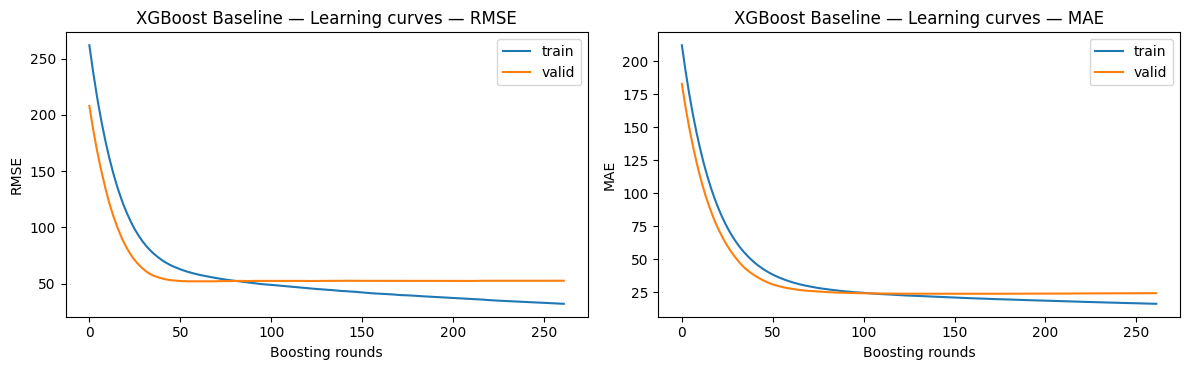

In [ ]:
# Cell — XGBoost baseline

import xgboost as xgb
import numpy as np
import pandas as pd
from time import time

FEATS       = ML_DATA["FEATS"]
TARGET_COL  = ML_DATA["TARGET_COL"]
H           = int(ML_DATA["H_STEPS"])

# tiny helpers
def day_mask_at_target(idx, h=H):
    if "is_day" not in df_features.columns:
        return np.ones(len(idx), dtype=bool)
    return df_features.loc[idx, "is_day"].shift(-h).fillna(False).to_numpy().astype(bool)

def predict_best(booster, dmat):
    try:
        return booster.predict(dmat, iteration_range=(0, booster.best_iteration + 1))
    except TypeError:
        lim = getattr(booster, "best_ntree_limit", 0) or getattr(booster, "best_iteration", 0) + 1
        return booster.predict(dmat, ntree_limit=lim)

# train/val from Cell 6 data split
tr_idx = ML_DATA["index"]["train"]
va_idx = ML_DATA["index"]["val"]
te_idx = ML_DATA["index"]["test"]

Xtr = df_features.loc[tr_idx, FEATS].astype(np.float32)
Xva = df_features.loc[va_idx, FEATS].astype(np.float32)
ytr = df_features.loc[tr_idx, TARGET_COL].astype(np.float32).to_numpy()
yva = df_features.loc[va_idx, TARGET_COL].astype(np.float32).to_numpy()

# drop any inf/nan rows
mask_tr = np.isfinite(ytr) & Xtr.replace([np.inf, -np.inf], np.nan).notna().all(axis=1).to_numpy()
mask_va = np.isfinite(yva) & Xva.replace([np.inf, -np.inf], np.nan).notna().all(axis=1).to_numpy()
Xtr, ytr = Xtr.iloc[mask_tr], ytr[mask_tr]
Xva, yva = Xva.iloc[mask_va], yva[mask_va]

dtr = xgb.DMatrix(Xtr, label=ytr, feature_names=FEATS)
dva = xgb.DMatrix(Xva, label=yva, feature_names=FEATS)

# model & training
tree_method = "gpu_hist" if tf.config.list_physical_devices('GPU') else "hist"
params_base = {
    "objective": "reg:squarederror",
    "eval_metric": ["rmse", "mae"],
    "tree_method": tree_method,
    "seed": SEED,
    "eta": 0.05,
    "max_depth": 7,
    "min_child_weight": 5.0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "gamma": 0.0,
    "lambda": 2.0,
    "alpha": 0.0,
}
num_boost_round = 2500
early_stopping_rounds = 100
evals_result_base = {}

_ = xgb.train(
    params_base,
    dtr,
    num_boost_round=num_boost_round,
    evals=[(dtr, "train"), (dva, "valid")],
    early_stopping_rounds=early_stopping_rounds,
    evals_result=evals_result_base,
    verbose_eval=False,
)

# TEST index
# build day-at-target subset
te_mask_day = day_mask_at_target(te_idx, H)
te_idx_day  = te_idx[te_mask_day]

te_tbl = df_features.loc[te_idx_day, FEATS].astype(np.float32).copy()
te_tbl["y_t"]  = df_model.loc[te_idx_day, "ghi"].astype(np.float32).values
te_tbl["y_tH"] = df_features.loc[te_idx_day, TARGET_COL].astype(np.float32).values
te_tbl = te_tbl.replace([np.inf, -np.inf], np.nan).dropna(axis=0, how="any")

TEST_DAY_INDEX = te_tbl.index


# learning curves
try:
    plot_xgb_learning_curves(evals_result_base, title="XGBoost Baseline — Learning curves")
except NameError:
    import matplotlib.pyplot as plt
    tr = evals_result_base.get("train", {})
    va = evals_result_base.get("valid", {})
    plt.figure(figsize=(8,4))
    if "rmse" in tr and "rmse" in va:
        plt.plot(tr["rmse"], label="train RMSE")
        plt.plot(va["rmse"], label="valid RMSE")
    if "mae" in tr and "mae" in va:
        plt.plot(tr["mae"], label="train MAE", linestyle="--")
        plt.plot(va["mae"], label="valid MAE", linestyle="--")
    plt.xlabel("Boosting rounds"); plt.ylabel("Metric"); plt.title("XGB Baseline — Learning curves")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


In [ ]:
# Cell: Optuna tuning for XGBoost

import optuna, xgboost as xgb, numpy as np, pandas as pd
from time import time

print("Running Optuna for XGBoost tuned model")

# Configuration
H            = int(ML_DATA["H_STEPS"])    # forecasting horizon in steps
ALPHA_DIR    = 0.15                       # weight for directional-accuracy term
MOVE_THRESH  = 25.0                       # W/m² change to count as a “real” ramp
N_TRIALS     = 80
VAL_FRAC     = 0.12
GAP          = 100
MIN_TRAIN    = 3000

# Helpers
def _rmse(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    return float(np.sqrt(np.mean((a - b) ** 2)))

def _dir_acc(y_true, y_pred, y_now, thr=MOVE_THRESH):
    delta_t = y_true - y_now
    delta_p = y_pred - y_now
    mask = np.abs(delta_t) >= thr
    if not np.any(mask):  # if nothing to score, be neutral
        return 0.5
    return float(np.mean(np.sign(delta_t[mask]) == np.sign(delta_p[mask])))

def day_mask_at_target(idx, h=H):
    if "is_day" not in df_features.columns:
        return np.ones(len(idx), dtype=bool)
    return df_features.loc[idx, "is_day"].shift(-h).fillna(False).to_numpy().astype(bool)

def predict_best(booster, dmat):
    try:
        return booster.predict(dmat, iteration_range=(0, booster.best_iteration + 1))
    except TypeError:
        lim = getattr(booster, "best_ntree_limit", 0) or getattr(booster, "best_iteration", 0) + 1
        return booster.predict(dmat, ntree_limit=lim)

def make_expanding_folds(n, n_folds=3, val_frac=VAL_FRAC, gap=GAP, min_train=MIN_TRAIN):
    folds, v = [], max(1, int(n * val_frac))
    end = n
    for _ in range(n_folds):
        start_val = max(end - v, 0)
        end_train = max(start_val - gap, 0)
        if end_train < min_train: break
        folds.append((slice(0, end_train), slice(start_val, end)))
        end = start_val
    return list(reversed(folds))

# DEV table (train∪val, day-only, cleaned)
FEATS = ML_DATA["FEATS"]
TARGET_COL = ML_DATA["TARGET_COL"]

dev_idx_full = ML_DATA["index"]["train"].union(ML_DATA["index"]["val"])
dev_idx_day  = dev_idx_full[day_mask_at_target(dev_idx_full)]

X_dev = df_features.loc[dev_idx_day, FEATS].astype(np.float32).replace([np.inf, -np.inf], np.nan)
y_tH  = df_features.loc[dev_idx_day, TARGET_COL].astype(np.float32)   # y_{t+H}
y_t   = df_model.loc[dev_idx_day, "ghi"].astype(np.float32)           # y_t

finite = X_dev.notna().all(axis=1) & np.isfinite(y_tH) & np.isfinite(y_t)
X_dev = X_dev.loc[finite]
y_tH  = y_tH.loc[finite]
y_t   = y_t.loc[finite]

# Ramp-aware weights: upweight rapid changes a bit
ramp_now = (np.abs(y_t.values - y_t.shift(1).fillna(method="bfill").values) >= MOVE_THRESH).astype(float)
w_dev = (0.2 + 0.8 * (y_t.values / (float(y_t.values.mean()) + 1e-6))).astype(np.float32)
w_dev *= (1.0 + 0.25 * ramp_now).astype(np.float32)

print(f"[DEV] rows after cleaning: {len(X_dev)} | features: {X_dev.shape[1]}")
folds = make_expanding_folds(len(X_dev))
print("CV folds (end_train, start_val, end_val):",
      [(f[0].stop, f[1].start, f[1].stop) for f in folds])

# choose tree method
try:
    import tensorflow as tf
    tree_method = "gpu_hist" if tf.config.list_physical_devices('GPU') else "hist"
except Exception:
    tree_method = "hist"

# monotone constraints for sun geometry
mono_vec = [0] * len(FEATS)
for f in ("cos_zenith", "solar_elevation"):
    if f in FEATS:
        mono_vec[FEATS.index(f)] = 1

# Optuna objective
def objective(trial: optuna.Trial):
    # try residual vs level training
    target_mode = trial.suggest_categorical("target_mode", ["residual", "level"])
    y_label = (y_tH.values - y_t.values).astype(np.float32) if target_mode == "residual" else y_tH.values.astype(np.float32)

    params = {
        "objective": trial.suggest_categorical("objective", ["reg:squarederror", "reg:pseudohubererror"]),
        "eval_metric": ["rmse", "mae"],
        "tree_method": tree_method,
        "seed": SEED,
        "eta": trial.suggest_float("eta", 0.01, 0.08, log=True),
        "max_depth": trial.suggest_int("max_depth", 5, 9),
        "min_child_weight": trial.suggest_float("min_child_weight", 3.0, 10.0),
        "subsample": trial.suggest_float("subsample", 0.70, 1.00),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.70, 1.00),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.60, 1.00),
        "gamma": trial.suggest_float("gamma", 0.0, 3.0),
        "lambda": trial.suggest_float("lambda", 1.0, 15.0),
        "alpha": trial.suggest_float("alpha", 0.0, 3.0),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "max_bin": trial.suggest_int("max_bin", 128, 512),
    }
    if params["grow_policy"] == "lossguide":
        params["max_leaves"] = trial.suggest_int("max_leaves", 64, 512)
    # optional monotonicity
    use_mono = trial.suggest_categorical("use_monotone", [0, 1])
    if use_mono and any(mono_vec):
        params["monotone_constraints"] = "(" + ",".join(str(v) for v in mono_vec) + ")"

    # gentle LR decay
    eta0 = float(params["eta"])
    def _sched(epoch, eta0=eta0):  # keep signature (epoch) >lr
        return max(eta0 * (0.997 ** epoch), 1e-4)
    lr_decay = xgb.callback.LearningRateScheduler(_sched)

    scores = []
    for tr_sl, va_sl in folds:
        Xtr, Xva = X_dev.iloc[tr_sl], X_dev.iloc[va_sl]
        ytr, yva = y_label[tr_sl],   y_label[va_sl]
        wtr, wva = w_dev[tr_sl],     w_dev[va_sl]

        # safety
        good_tr = np.isfinite(ytr); Xtr, ytr, wtr = Xtr.iloc[good_tr], ytr[good_tr], wtr[good_tr]
        good_va = np.isfinite(yva); Xva, yva, wva = Xva.iloc[good_va], yva[good_va], wva[good_va]

        dtr = xgb.DMatrix(Xtr, label=ytr, weight=wtr, feature_names=FEATS)
        dva = xgb.DMatrix(Xva, label=yva, weight=wva, feature_names=FEATS)

        booster = xgb.train(
            params, dtr,
            num_boost_round=3200,
            evals=[(dtr, "train"), (dva, "valid")],
            early_stopping_rounds=140,
            verbose_eval=False,
            callbacks=[lr_decay],
        )

        # reconstruct to level for scoring
        yhat = predict_best(booster, dva)
        idx_va = Xva.index
        y_true_va = df_features.loc[idx_va, TARGET_COL].to_numpy().astype(np.float32)
        y_now_va  = df_model.loc[idx_va, "ghi"].to_numpy().astype(np.float32)
        y_pred_va = (y_now_va + yhat) if target_mode == "residual" else yhat

        r = _rmse(y_true_va, y_pred_va)
        da = _dir_acc(y_true_va, y_pred_va, y_now_va, thr=MOVE_THRESH)
        scores.append(r * (1.0 + ALPHA_DIR * (1.0 - da)))

    trial.set_user_attr("target_mode", target_mode)
    return float(np.mean(scores))

# Run search
sampler = optuna.samplers.TPESampler(seed=SEED)
pruner  = optuna.pruners.MedianPruner(n_startup_trials=10)
study   = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)

t0 = time()
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)
opt_time = time() - t0

best_params       = study.best_trial.params.copy()
best_target_mode  = study.best_trial.user_attrs.get("target_mode", "residual")

print("\nBest tuned params")
for k, v in best_params.items():
    print(f"  {k}: {v}")
print(f"  target_mode: {best_target_mode}")
print(f"Optuna time: {opt_time:.2f}s")

# simple fold diagnostics for the winning setting
def _eval_params(params, target_mode):
    out = []
    base = {"eval_metric": ["rmse","mae"], "tree_method": tree_method, "seed": SEED, **params}
    eta0 = float(base.get("eta", 0.03))
    def _sched(epoch, eta0=eta0): return max(eta0 * (0.997 ** epoch), 1e-4)
    lr_decay = xgb.callback.LearningRateScheduler(_sched)

    y_lab = (y_tH.values - y_t.values).astype(np.float32) if target_mode == "residual" else y_tH.values.astype(np.float32)
    for tr_sl, va_sl in folds:
        Xtr, Xva = X_dev.iloc[tr_sl], X_dev.iloc[va_sl]
        ytr, yva = y_lab[tr_sl], y_lab[va_sl]
        wtr, wva = w_dev[tr_sl], w_dev[va_sl]
        dtr = xgb.DMatrix(Xtr, label=ytr, weight=wtr, feature_names=FEATS)
        dva = xgb.DMatrix(Xva, label=yva, weight=wva, feature_names=FEATS)
        booster = xgb.train(base, dtr, num_boost_round=3200,
                            evals=[(dtr,"train"),(dva,"valid")],
                            early_stopping_rounds=140, verbose_eval=False,
                            callbacks=[lr_decay])
        yhat = predict_best(booster, dva)
        idx = Xva.index
        yt  = df_features.loc[idx, TARGET_COL].to_numpy().astype(np.float32)
        y0  = df_model.loc[idx, "ghi"].to_numpy().astype(np.float32)
        yp  = y0 + yhat if target_mode == "residual" else yhat
        out.append((_rmse(yt, yp), _dir_acc(yt, yp, y0)))
    return out

fold_stats = _eval_params(best_params, best_target_mode)
print("\nBest params — per-fold diagnostics:")
for i,(r,da) in enumerate(fold_stats,1):
    print(f"  Fold {i}: RMSE={r:.2f}, DirAcc={da:.3f}")
print(f"  Mean RMSE={np.mean([r for r,_ in fold_stats]):.2f}, Mean DirAcc={np.mean([da for _,da in fold_stats]):.3f}")

# artifacts
BEST_XGB_PARAMS_1H   = best_params
BEST_TARGET_MODE_1H  = best_target_mode
BEST_MONOTONE_VEC_1H = mono_vec


[I 2025-08-23 21:26:07,565] A new study created in memory with name: no-name-a84ad278-b52a-4cc5-bc02-eba9f4902814


Running Optuna for XGBoost tuned model
[DEV] rows after cleaning: 7673 | features: 28
CV folds (end_train, start_val, end_val): [(4813, 4913, 5833), (5733, 5833, 6753), (6653, 6753, 7673)]


  0%|          | 0/80 [00:00<?, ?it/s]

[I 2025-08-23 21:27:03,953] Trial 0 finished with value: 96.75310119105792 and parameters: {'target_mode': 'level', 'objective': 'reg:squarederror', 'eta': 0.013832442448846112, 'max_depth': 5, 'min_child_weight': 3.406585285177396, 'subsample': 0.9598528437324805, 'colsample_bytree': 0.8803345035229626, 'colsample_bynode': 0.8832290311184181, 'gamma': 0.06175348288740734, 'lambda': 14.57873793026792, 'alpha': 2.497327922401265, 'grow_policy': 'depthwise', 'max_bin': 198, 'use_monotone': 1}. Best is trial 0 with value: 96.75310119105792.
[I 2025-08-23 21:27:40,793] Trial 1 finished with value: 95.53346135126678 and parameters: {'target_mode': 'residual', 'objective': 'reg:squarederror', 'eta': 0.01835831878100654, 'max_depth': 6, 'min_child_weight': 6.192489889519251, 'subsample': 0.935552788417904, 'colsample_bytree': 0.7599021346475079, 'colsample_bynode': 0.8056937753654446, 'gamma': 1.7772437065861273, 'lambda': 1.6503057780799681, 'alpha': 1.822634555704315, 'grow_policy': 'depthw

[DEV day-only] 7673 rows 
[TEST day-only] 1029 rows

=== XGBoost Tuned — Test (day-only) ===
ALL_MAE: 38.4480
ALL_RMSE: 57.8317
ALL_R2: 0.8326
DAY_nRMSE: 0.3701
DIR_ACC: 0.9031
Train time: 29.64s | Inference time (test): 0.02s


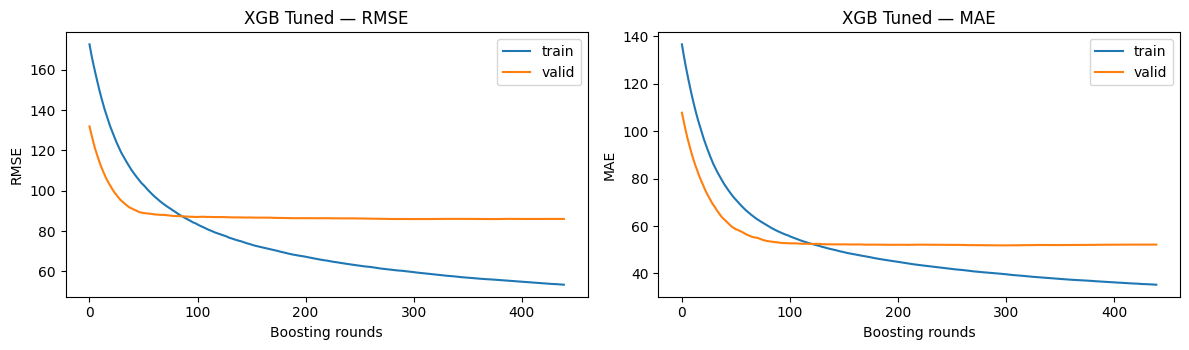

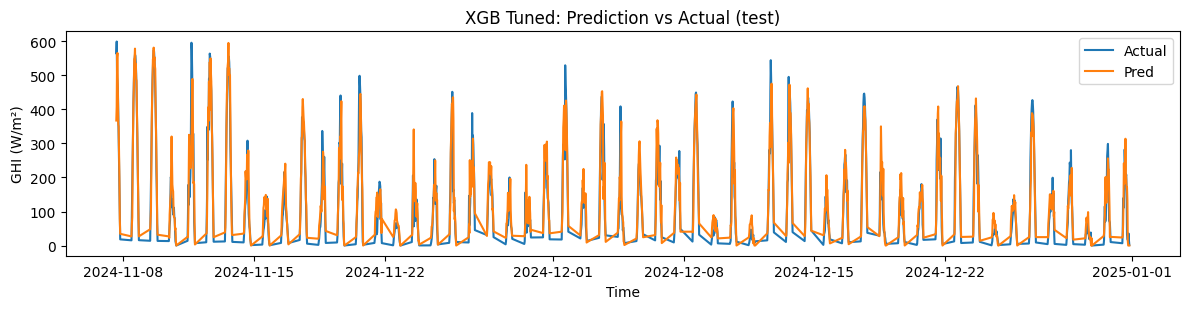

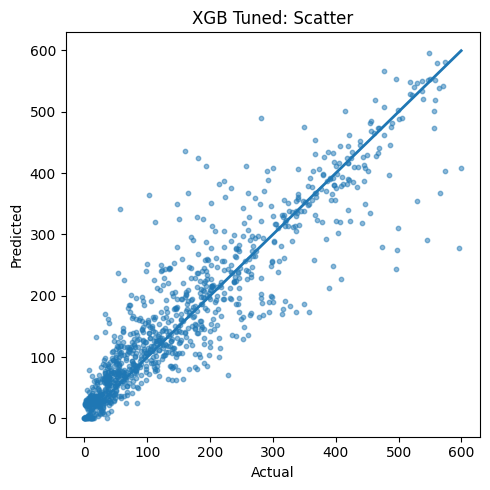

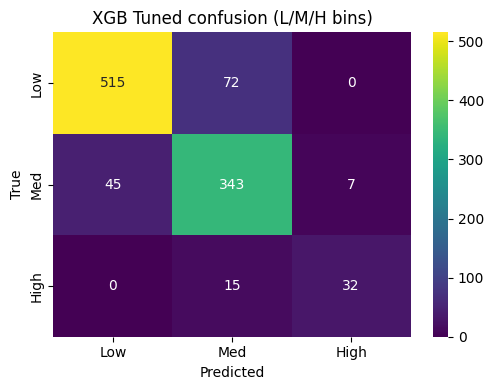

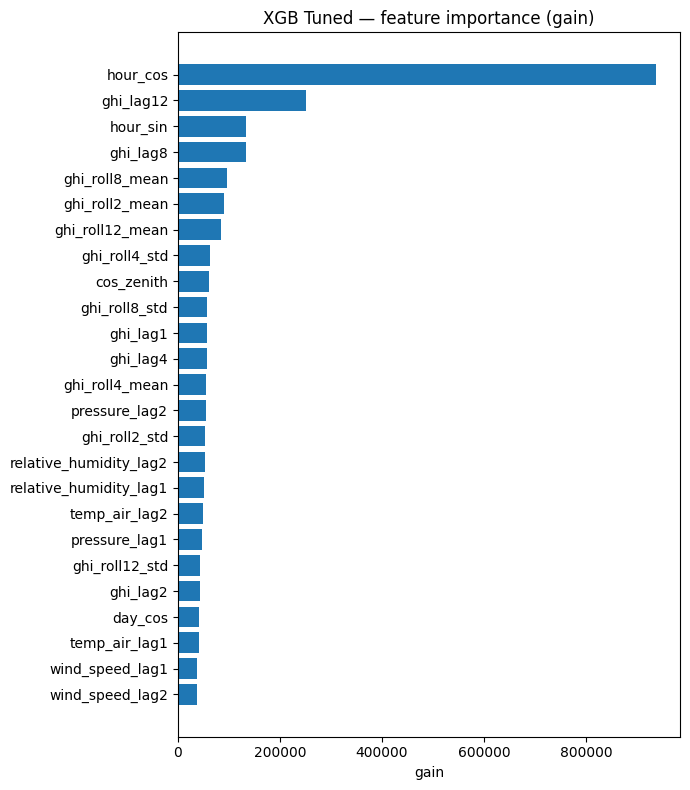

In [ ]:
# Cell 16 — Final tuned XGBoost

import xgboost as xgb, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from time import time

FEATS      = ML_DATA["FEATS"]
TARGET_COL = ML_DATA["TARGET_COL"]
H          = int(ML_DATA["H_STEPS"])
MOVE_THRESH = 25.0

# Small helpers
def _rmse(a, b): a=np.asarray(a,float); b=np.asarray(b,float); return float(np.sqrt(np.mean((a-b)**2)))
def _mae(a, b):  a=np.asarray(a,float); b=np.asarray(b,float); return float(np.mean(np.abs(a-b)))
def _r2(y, yhat): y=np.asarray(y,float); yhat=np.asarray(yhat,float); sst=np.sum((y-y.mean())**2); sse=np.sum((y-yhat)**2); return float(1.0 - sse/(sst+1e-12))
def day_mask_at_target(idx, h=H):
    if "is_day" not in df_features.columns: return np.ones(len(idx), dtype=bool)
    return df_features.loc[idx, "is_day"].shift(-h).fillna(False).to_numpy().astype(bool)
def predict_best(booster, dmat):
    try:    return booster.predict(dmat, iteration_range=(0, booster.best_iteration + 1))
    except TypeError:
        lim = getattr(booster, "best_ntree_limit", 0) or getattr(booster, "best_iteration", 0) + 1
        return booster.predict(dmat, ntree_limit=lim)

def plot_xgb_learning_curves(evals_result, title="XGB Tuned"):
    tr, va = evals_result.get("train", {}), evals_result.get("valid", {})
    fig, ax = plt.subplots(1,2, figsize=(12,3.6), sharex=True)
    if "rmse" in tr and "rmse" in va:
        ax[0].plot(tr["rmse"], label="train"); ax[0].plot(va["rmse"], label="valid")
        ax[0].set_title(f"{title} — RMSE"); ax[0].set_xlabel("Boosting rounds"); ax[0].set_ylabel("RMSE"); ax[0].legend()
    if "mae" in tr and "mae" in va:
        ax[1].plot(tr["mae"], label="train"); ax[1].plot(va["mae"], label="valid")
        ax[1].set_title(f"{title} — MAE"); ax[1].set_xlabel("Boosting rounds"); ax[1].set_ylabel("MAE"); ax[1].legend()
    plt.tight_layout(); plt.show()

def plot_pred_vs_actual(idx, y_true, y_pred, title=""):
    plt.figure(figsize=(12,3.2))
    plt.plot(idx, y_true, label="Actual"); plt.plot(idx, y_pred, label="Pred")
    plt.title(title); plt.xlabel("Time"); plt.ylabel("GHI (W/m²)"); plt.legend(); plt.tight_layout(); plt.show()

def plot_scatter(y, yp, title=""):
    y, yp = np.asarray(y,float), np.asarray(yp,float)
    plt.figure(figsize=(5,5))
    plt.scatter(y, yp, s=10, alpha=0.5)
    mn, mx = np.nanmin(y), np.nanmax(y); plt.plot([mn,mx],[mn,mx], lw=2)
    plt.title(title); plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.tight_layout(); plt.show()

def make_bins(y):
    q1, q2 = np.quantile(np.asarray(y,float), [1/3, 2/3])
    return q1, q2

def plot_confusion(y_true, y_pred, q1, q2, title=""):
    yb = np.digitize(y_true, [q1, q2]); pb = np.digitize(y_pred, [q1, q2])
    m = np.zeros((3,3), dtype=int)
    for t,p in zip(yb, pb): m[t, p] += 1
    import seaborn as sns
    plt.figure(figsize=(5.2,4))
    sns.heatmap(m, annot=True, fmt="d", cmap="viridis")
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("True"); plt.xticks([0.5,1.5,2.5],["Low","Med","High"]); plt.yticks([0.5,1.5,2.5],["Low","Med","High"])
    plt.tight_layout(); plt.show()

def plot_gain_importance(booster, top_k=25, title="Feature importance (gain)"):
    score = booster.get_score(importance_type="gain")
    if not score: return
    items = sorted(score.items(), key=lambda x: x[1], reverse=True)[:top_k]
    names, vals = zip(*items)
    vals = np.array(vals, float)
    plt.figure(figsize=(7,8)); plt.barh(range(len(names)), vals); plt.yticks(range(len(names)), names)
    plt.gca().invert_yaxis(); plt.xlabel("gain"); plt.title(title); plt.tight_layout(); plt.show()

# DEV
dev_idx_full = ML_DATA["index"]["train"].union(ML_DATA["index"]["val"])
dev_idx_day  = dev_idx_full[day_mask_at_target(dev_idx_full)]

if "TEST_DAY_INDEX" in globals():
    test_idx_day = TEST_DAY_INDEX
else:
    te_idx = ML_DATA["index"]["test"]
    test_idx_day = te_idx[day_mask_at_target(te_idx)]

# Build DEV table
dev = df_features.loc[dev_idx_day, FEATS].astype(np.float32).copy()
dev["y_t"]  = df_model.loc[dev_idx_day, "ghi"].astype(np.float32).values
dev["y_tH"] = df_features.loc[dev_idx_day, TARGET_COL].astype(np.float32).values
dev = dev.replace([np.inf, -np.inf], np.nan).dropna(axis=0, how="any")

# residual
target_mode = globals().get("BEST_TARGET_MODE_1H", "residual")
dev["y_lab"] = (dev["y_tH"] - dev["y_t"]).astype(np.float32) if target_mode == "residual" else dev["y_tH"].astype(np.float32)

# ramp-aware weights again
ramp = (np.abs(dev["y_t"].values - pd.Series(dev["y_t"].values).shift(1).fillna(method="bfill").values) >= MOVE_THRESH).astype(float)
w_dev = (0.2 + 0.8*(dev["y_t"].values / (float(dev["y_t"].values.mean())+1e-6))).astype(np.float32) * (1.0 + 0.25*ramp).astype(np.float32)

X_dev = dev[FEATS].astype(np.float32)
y_lab = dev["y_lab"].values.astype(np.float32)

# TEST table
te  = df_features.loc[test_idx_day, FEATS].astype(np.float32).copy()
te["y_t"]  = df_model.loc[test_idx_day, "ghi"].astype(np.float32).values
te["y_tH"] = df_features.loc[test_idx_day, TARGET_COL].astype(np.float32).values
te = te.replace([np.inf, -np.inf], np.nan).dropna(axis=0, how="any")
X_te = te[FEATS].astype(np.float32); y_t_te = te["y_t"].values.astype(np.float32); y_tH_te = te["y_tH"].values.astype(np.float32)

print(f"[DEV day-only] {len(X_dev)} rows \n[TEST day-only] {len(X_te)} rows")

# Split DEV for early stopping
cut = int(0.85 * len(X_dev))
Xtr, Xva = X_dev.iloc[:cut], X_dev.iloc[cut:]
ytr, yva = y_lab[:cut],     y_lab[cut:]
wtr, wva = w_dev[:cut],     w_dev[cut:]

dtr = xgb.DMatrix(Xtr, label=ytr, weight=wtr, feature_names=FEATS)
dva = xgb.DMatrix(Xva, label=yva, weight=wva, feature_names=FEATS)
dte = xgb.DMatrix(X_te, feature_names=FEATS)

# Parameters
try:
    import tensorflow as tf
    tree_method = "gpu_hist" if tf.config.list_physical_devices('GPU') else "hist"
except Exception:
    tree_method = "hist"

best = dict(globals().get("BEST_XGB_PARAMS_1H", {}))
params = {
    "eval_metric": ["rmse","mae"],
    "tree_method": tree_method,
    "seed": SEED,
    **best
}
# monotone constraints
mono_vec = globals().get("BEST_MONOTONE_VEC_1H", None)
if mono_vec and any(mono_vec):
    params["monotone_constraints"] = "(" + ",".join(str(int(v)) for v in mono_vec) + ")"

# learning-rate schedule
eta0 = float(params.get("eta", 0.03))
def _sched(epoch, eta0=eta0): return max(eta0 * (0.997 ** epoch), 1e-4)
lr_decay = xgb.callback.LearningRateScheduler(_sched)

num_boost_round = 3200
esr = 140
evals_result = {}

# train tuned model
t0 = time()
booster = xgb.train(
    params, dtr, num_boost_round=num_boost_round,
    evals=[(dtr,"train"), (dva,"valid")],
    early_stopping_rounds=esr,
    evals_result=evals_result,
    verbose_eval=False,
    callbacks=[lr_decay],
)
train_time = time() - t0

# Predict, reconstruct to level, and clamp
t1 = time()
yhat_lab = predict_best(booster, dte)
y_hat = (y_t_te + yhat_lab) if (params.get("objective","reg:squarederror") and target_mode=="residual") else yhat_lab
# physics guardrails
upper = np.percentile(y_t_te, 99.9)
y_hat = np.clip(y_hat, 0.0, upper)
infer_time = time() - t1

# Metrics
rmse = _rmse(y_tH_te, y_hat)
mae  = _mae(y_tH_te, y_hat)
r2   = _r2(y_tH_te, y_hat)
nrmse_mean = rmse / (y_tH_te.mean() + 1e-6)
dir_acc = _dir_acc(y_tH_te, y_hat, y_t_te, thr=MOVE_THRESH)

print("\n=== XGBoost Tuned — Test (day-only) ===")
print(f"ALL_MAE: {mae:.4f}")
print(f"ALL_RMSE: {rmse:.4f}")
print(f"ALL_R2: {r2:.4f}")
print(f"DAY_nRMSE: {nrmse_mean:.4f}")
print(f"DIR_ACC: {dir_acc:.4f}")
print(f"Train time: {train_time:.2f}s | Inference time (test): {infer_time:.2f}s")

# Plots
plot_xgb_learning_curves(evals_result, title="XGB Tuned")
plot_pred_vs_actual(X_te.index, y_tH_te, y_hat, title="XGB Tuned: Prediction vs Actual (test)")
plot_scatter(y_tH_te, y_hat, title="XGB Tuned: Scatter")

q1, q2 = make_bins(dev["y_tH"].values)
plot_confusion(y_tH_te, y_hat, q1, q2, title="XGB Tuned confusion (L/M/H bins)")
plot_gain_importance(booster, top_k=25, title="XGB Tuned — feature importance (gain)")


## GRU Baseline and optimised

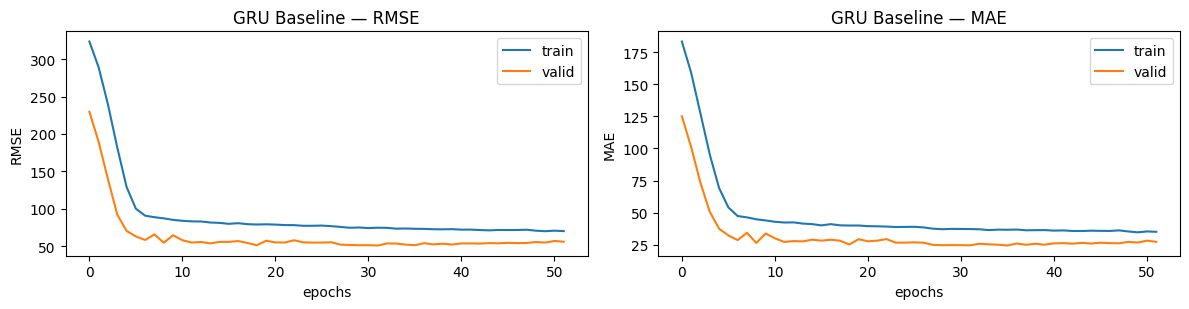

In [ ]:
# Cell GRU 1: GRU baseline

import numpy as np, pandas as pd, tensorflow as tf, matplotlib.pyplot as plt
from tensorflow.keras import layers, models, callbacks, regularizers
from sklearn.preprocessing import StandardScaler

SEED = int(globals().get("SEED", 2024))
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

FEATS      = ML_DATA["FEATS"]
TARGET_COL = ML_DATA["TARGET_COL"]
H          = int(ML_DATA["H_STEPS"])           # horizon in steps

# Helpers
def day_mask_at_target(idx, h=H):
    if "is_day" not in df_features.columns:
        return np.ones(len(idx), dtype=bool)
    return df_features.loc[idx, "is_day"].shift(-h).fillna(False).to_numpy().astype(bool)

def make_seq_arrays(full_df, feat_cols, index_like, lookback):
    """Builds (X, y, y_now, idx_out) with rolling windows that end at row i."""
    full_df = full_df.replace([np.inf, -np.inf], np.nan)
    arr = full_df[feat_cols].astype(np.float32).to_numpy()
    idx_full = full_df.index.to_numpy()
    pos = {k:i for i,k in enumerate(idx_full)}

    X, y, y_now, idx_out = [], [], [], []
    for k in index_like:
        i = pos.get(k, None)
        if i is None or i - lookback + 1 < 0:
            continue
        win = arr[i - lookback + 1 : i + 1]
        if np.isnan(win).any():
            continue
        X.append(win)
        y.append(float(full_df.at[k, TARGET_COL]))             # y_{t+H}
        y_now.append(float(df_model.at[k, "ghi"]))              # y_t
        idx_out.append(k)
    if len(X) == 0:
        return np.zeros((0, lookback, len(feat_cols)), np.float32), np.array([]), np.array([]), np.array([])
    return np.stack(X), np.array(y, np.float32), np.array(y_now, np.float32), np.array(idx_out)

def build_gru(input_shape, units=64, dropout=0.2, l2=0.0):
    reg = regularizers.l2(l2) if l2>0 else None
    inp = layers.Input(shape=input_shape)
    x   = layers.GRU(units, dropout=dropout, recurrent_dropout=0.0,
                     kernel_regularizer=reg, recurrent_regularizer=reg, return_sequences=False)(inp)
    x   = layers.Dense(units//2, activation="relu", kernel_regularizer=reg)(x)
    out = layers.Dense(1, name="yhat")(x)
    model = models.Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-3, clipnorm=1.0),
                  loss="mse", metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae"),
                                       tf.keras.metrics.RootMeanSquaredError(name="rmse")])
    return model

# From data split
tr_idx = ML_DATA["index"]["train"]
va_idx = ML_DATA["index"]["val"]

# Sequences # window
LOOKBACK = max(24, H*6)
Xtr, ytr, ynow_tr, idx_tr = make_seq_arrays(df_features, FEATS, tr_idx, LOOKBACK)
Xva, yva, ynow_va, idx_va = make_seq_arrays(df_features, FEATS, va_idx, LOOKBACK)

# scale per feature using train windows only
scaler = StandardScaler()
Xtr_2d = Xtr.reshape(-1, Xtr.shape[-1])
scaler.fit(Xtr_2d)
def transform_3d(X):
    if X.size == 0: return X
    s = X.shape
    Z = scaler.transform(X.reshape(-1, s[-1])).reshape(s)
    return Z

Xtr_s, Xva_s = transform_3d(Xtr), transform_3d(Xva)

# build model and train
model_base = build_gru(input_shape=(LOOKBACK, len(FEATS)), units=64, dropout=0.2, l2=1e-5)
es  = callbacks.EarlyStopping(patience=20, restore_best_weights=True, monitor="val_loss")
rlr = callbacks.ReduceLROnPlateau(factor=0.5, patience=8, min_lr=1e-5, monitor="val_loss")

hist = model_base.fit(
    Xtr_s, ytr,
    validation_data=(Xva_s, yva),
    epochs=200,
    batch_size=256,
    verbose=0,
    callbacks=[es, rlr],
)

# Test
try:
    _ = TEST_DAY_INDEX
except NameError:
    te_idx = ML_DATA["index"]["test"]
    mask_day = day_mask_at_target(te_idx, H)
    TEST_DAY_INDEX = te_idx[mask_day]

# Learning curves
plt.figure(figsize=(12,3.2))
plt.subplot(1,2,1); plt.plot(hist.history["rmse"], label="train"); plt.plot(hist.history["val_rmse"], label="valid")
plt.title("GRU Baseline — RMSE"); plt.xlabel("epochs"); plt.ylabel("RMSE"); plt.legend()
plt.subplot(1,2,2); plt.plot(hist.history["mae"], label="train"); plt.plot(hist.history["val_mae"], label="valid")
plt.title("GRU Baseline — MAE"); plt.xlabel("epochs"); plt.ylabel("MAE"); plt.legend()
plt.tight_layout(); plt.show()


In [ ]:
#Cell G2: Optuna tuning for GRU

import time, numpy as np, pandas as pd, optuna, tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from sklearn.preprocessing import StandardScaler

# Constants
TARGET_MODE_CHOICES = ("level", "residual")
LOOKBACK_CHOICES    = (36, 48)
UNITS_CHOICES       = (64, 96, 128)
LAYERS_CHOICES      = (1, 2)
BATCH_CHOICES       = (128, 256)
CLIPNORM_CHOICES    = (1.0, 1.5)

N_TRIALS    = 40
N_FOLDS     = 2
MAX_EPOCHS  = 60
ES_PATIENCE = 5
RLROP_PAT   = 2

VAL_FRAC    = 0.12
GAP         = 100
MIN_TRAIN   = 3000
MOVE_THRESH = 25.0
ALPHA_DIR   = 0.15

SEED = int(globals().get("SEED", 2024))
tf.keras.utils.set_random_seed(SEED)

# mixed precision
try:
    tf.keras.mixed_precision.set_global_policy("mixed_float16")
except Exception:
    pass

FEATS      = ML_DATA["FEATS"]
TARGET_COL = ML_DATA["TARGET_COL"]
H          = int(ML_DATA["H_STEPS"])

def day_mask_at_target(idx, h=H):
    if "is_day" not in df_features.columns:
        return np.ones(len(idx), dtype=bool)
    return df_features.loc[idx, "is_day"].shift(-h).fillna(False).to_numpy().astype(bool)

def make_seq_arrays(frame: pd.DataFrame, feat_cols, index_like, lookback: int):
    frame = frame.replace([np.inf, -np.inf], np.nan)
    mat   = frame[feat_cols].astype(np.float32).to_numpy()
    idx_f = frame.index.to_numpy()
    pos   = {k:i for i,k in enumerate(idx_f)}
    X, yH, y0, out_idx = [], [], [], []
    for k in index_like:
        i = pos.get(k, None)
        if i is None or i - lookback + 1 < 0:
            continue
        win = mat[i - lookback + 1 : i + 1]
        if np.isnan(win).any():
            continue
        X.append(win)
        yH.append(float(frame.at[k, TARGET_COL]))   # y_{t+H}
        y0.append(float(df_model.at[k, "ghi"]))     # y_t
        out_idx.append(k)
    if not X:
        return (np.zeros((0, lookback, len(feat_cols)), np.float32),
                np.array([]), np.array([]), np.array([]))
    return np.stack(X), np.array(yH, np.float32), np.array(y0, np.float32), np.array(out_idx)

def make_folds(n, n_folds=N_FOLDS, val_frac=VAL_FRAC, gap=GAP, min_train=MIN_TRAIN):
    folds = []
    v = max(1, int(n * val_frac))
    end = n
    for _ in range(n_folds):
        start_val = max(end - v, 0)
        end_train = max(start_val - gap, 0)
        if end_train < min_train: break
        folds.append((slice(0, end_train), slice(start_val, end)))
        end = start_val
    return list(reversed(folds))

def build_gru(input_shape, units=128, layers_n=1, dropout=0.2, l2=0.0, lr=2e-3, clipnorm=1.0):
    reg = regularizers.l2(l2) if l2 > 0 else None
    inp = layers.Input(shape=input_shape)
    x = layers.GRU(units,
                   return_sequences=(layers_n > 1),
                   dropout=dropout,
                   recurrent_dropout=0.0,    # keep CuDNN fast-path
                   kernel_regularizer=reg,
                   recurrent_regularizer=reg)(inp)
    if layers_n > 1:
        x = layers.GRU(units // 2,
                       return_sequences=False,
                       dropout=dropout,
                       recurrent_dropout=0.0,
                       kernel_regularizer=reg,
                       recurrent_regularizer=reg)(x)
    x = layers.Dense(max(units // 2, 32), activation="relu", kernel_regularizer=reg)(x)
    out = layers.Dense(1, dtype="float32")(x)  # float32 head keeps metrics stable in mixed precision
    model = models.Model(inp, out)
    opt = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=clipnorm)
    model.compile(optimizer=opt, loss="mse",
                  metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae"),
                           tf.keras.metrics.RootMeanSquaredError(name="rmse")])
    return model

def rmse(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    return float(np.sqrt(np.mean((a - b) ** 2)))

# DEV windows
dev_idx_full = ML_DATA["index"]["train"].union(ML_DATA["index"]["val"])
dev_idx_day  = dev_idx_full[day_mask_at_target(dev_idx_full)]

LOOKBACK_MAX = max(LOOKBACK_CHOICES)   # 48
X_all, yH_all, y0_all, idx_all = make_seq_arrays(df_features, FEATS, dev_idx_day, LOOKBACK_MAX)

print(f"[DEV] day-only windows (max L={LOOKBACK_MAX}): {len(X_all)} | features: {X_all.shape[-1]}")
folds = make_folds(len(X_all))
print("CV folds (end_train, start_val, end_val):", [(f[0].stop, f[1].start, f[1].stop) for f in folds])

# Study
sampler = optuna.samplers.TPESampler(seed=SEED, multivariate=True)
pruner  = optuna.pruners.SuccessiveHalvingPruner(min_resource=8, reduction_factor=3)
STUDY_NAME = f"gru_1h_fast_{int(time.time())}"
study = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner, study_name=STUDY_NAME)

def objective(trial: optuna.Trial):
    # fixed categorical spaces (tuples) to avoid "dynamic value space"
    target_mode = trial.suggest_categorical("target_mode", TARGET_MODE_CHOICES)
    lookback    = trial.suggest_categorical("lookback", LOOKBACK_CHOICES)
    units       = trial.suggest_categorical("units", UNITS_CHOICES)
    layers_n    = trial.suggest_categorical("layers_n", LAYERS_CHOICES)
    batch_size  = trial.suggest_categorical("batch_size", BATCH_CHOICES)
    clipnorm    = trial.suggest_categorical("clipnorm", CLIPNORM_CHOICES)

    # continuous ranges
    dropout     = trial.suggest_float("dropout", 0.10, 0.35)
    l2          = trial.suggest_float("l2", 1e-6, 1e-4, log=True)
    lr          = trial.suggest_float("lr", 1e-3, 3e-3, log=True)

    fold_scores = []
    for tr_sl, va_sl in folds:
        Xtr = X_all[tr_sl][:, -lookback:, :]
        Xva = X_all[va_sl][:, -lookback:, :]
        ytr = yH_all[tr_sl].copy()
        yva = yH_all[va_sl].copy()
        y0_tr = y0_all[tr_sl]; y0_va = y0_all[va_sl]

        if target_mode == "residual":
            ytr -= y0_tr
            yva -= y0_va

        # scale features using train only
        sc = StandardScaler()
        sc.fit(Xtr.reshape(-1, Xtr.shape[-1]))
        def T(X):
            s = X.shape
            return sc.transform(X.reshape(-1, s[-1])).reshape(s)
        Xtr_s, Xva_s = T(Xtr), T(Xva)

        tf.keras.backend.clear_session()
        model = build_gru((lookback, Xtr.shape[-1]), units, layers_n, dropout, l2, lr, clipnorm)

        es  = callbacks.EarlyStopping(monitor="val_rmse", patience=ES_PATIENCE,
                                      restore_best_weights=True, min_delta=0.5)
        rlr = callbacks.ReduceLROnPlateau(monitor="val_rmse", factor=0.5,
                                          patience=RLROP_PAT, min_lr=5e-5)

        model.fit(Xtr_s, ytr, validation_data=(Xva_s, yva),
                  epochs=MAX_EPOCHS, batch_size=batch_size, verbose=0,
                  callbacks=[es, rlr])

        yhat_va = model.predict(Xva_s, verbose=0).reshape(-1)
        ypred   = (y0_va + yhat_va) if target_mode == "residual" else yhat_va
        ytrue   = (yva + y0_va)     if target_mode == "residual" else yva

        r = rmse(ytrue, ypred)
        big = np.abs(ytrue - y0_va) >= MOVE_THRESH
        if big.any():
            d_true = np.sign(ytrue[big] - y0_va[big])
            d_pred = np.sign(ypred[big] - y0_va[big])
            dir_acc = float(np.mean((d_true == d_pred).astype(float)))
        else:
            dir_acc = 0.5

        score = r * (1.0 + ALPHA_DIR * (1.0 - dir_acc))
        fold_scores.append(score)

        trial.report(score, step=len(fold_scores))
        if trial.should_prune():
            raise optuna.TrialPruned()

    return float(np.mean(fold_scores))

t0 = time.time()
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)
print(f"Optuna time: {time.time() - t0:.2f}s")

best_params = study.best_trial.params
print("\nBest GRU params")
for k, v in best_params.items():
    print(f"  {k}: {v}")

BEST_GRU_PARAMS_1H = best_params

# Save
try:
    df_trials = study.trials_dataframe()
    df_trials.to_csv("gru_optuna_trials.csv", index=False)
    print("Saved: gru_optuna_trials.csv")
except Exception:
    pass


[I 2025-08-24 01:07:30,792] A new study created in memory with name: gru_1h_fast_1755997650


[DEV] day-only windows (max L=48): 7557 | features: 28
CV folds (end_train, start_val, end_val): [(5645, 5745, 6651), (6551, 6651, 7557)]


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-08-24 01:11:38,465] Trial 0 finished with value: 86.61718723718721 and parameters: {'target_mode': 'residual', 'lookback': 36, 'units': 64, 'layers_n': 1, 'batch_size': 128, 'clipnorm': 1.0, 'dropout': 0.15308477766956904, 'l2': 2.310201887845294e-06, 'lr': 0.00122322455316012}. Best is trial 0 with value: 86.61718723718721.
[I 2025-08-24 01:17:35,725] Trial 1 finished with value: 83.03253022367193 and parameters: {'target_mode': 'residual', 'lookback': 36, 'units': 64, 'layers_n': 2, 'batch_size': 128, 'clipnorm': 1.5, 'dropout': 0.11161260317999944, 'l2': 1.640928673064794e-05, 'lr': 0.0012060371447596414}. Best is trial 1 with value: 83.03253022367193.
[I 2025-08-24 01:22:32,389] Trial 2 finished with value: 85.98778139608461 and parameters: {'target_mode': 'residual', 'lookback': 36, 'units': 128, 'layers_n': 1, 'batch_size': 128, 'clipnorm': 1.0, 'dropout': 0.26563057108849547, 'l2': 4.201672054372532e-06, 'lr': 0.0017706613467123708}. Best is trial 1 with value: 83.032530

[DEV day-only] 7557 windows | [TEST day-only] 1011 windows | F=28


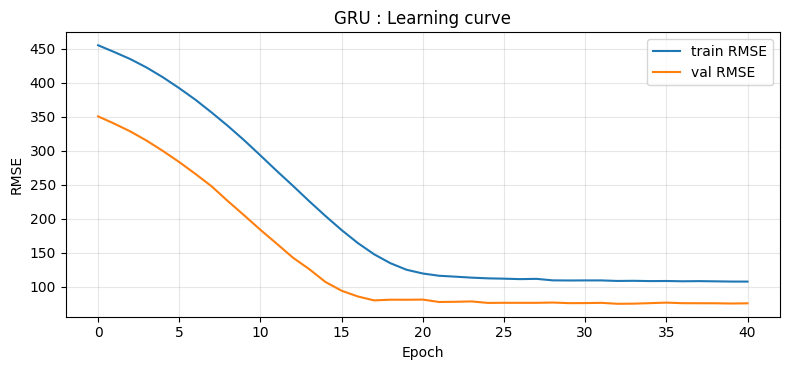


 GRU Tuned/Optimised: 
ALL_MAE: 41.4998
ALL_RMSE: 59.7563
ALL_R2: 0.8232
DIR_ACC (all day): 0.8289
Dir. accuracy (day, |Δ|≥25 W/m²): 0.872
Train time: 1369.17s | Inference time (test): 6.01s
Skill vs persistence (DAY): 31.8%


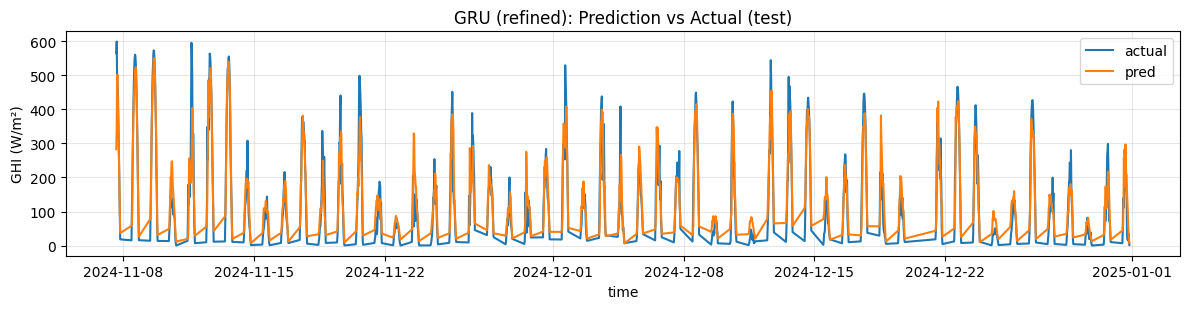

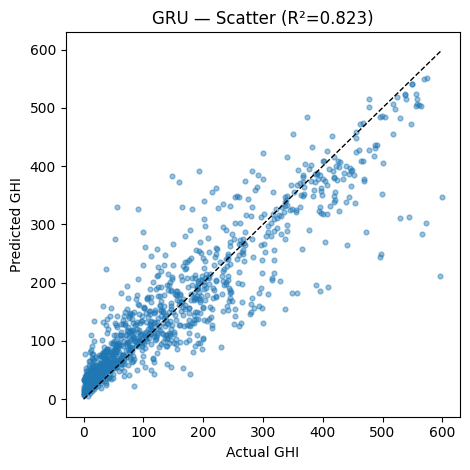

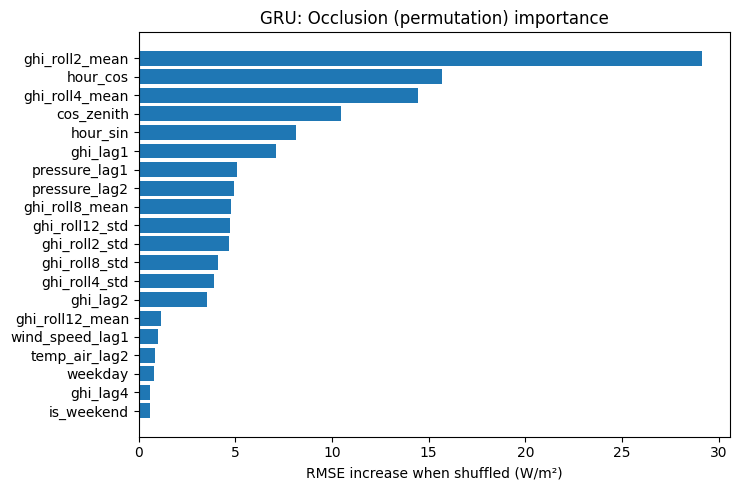

In [ ]:
# Cell G3 — GRU tuned

import time, math, numpy as np, pandas as pd, tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Configuration
SEED        = int(globals().get("SEED", 2024))
tf.keras.utils.set_random_seed(SEED)
try:
    tf.keras.mixed_precision.set_global_policy("mixed_float16")
except Exception:
    pass

FEATS      = ML_DATA["FEATS"]
TARGET_COL = ML_DATA["TARGET_COL"]
H          = int(ML_DATA["H_STEPS"])

# Exact day-only test index stored in previous cell
def day_mask_at_target(idx, h=H):
    if "is_day" not in df_features.columns:
        return np.ones(len(idx), dtype=bool)
    return df_features.loc[idx, "is_day"].shift(-h).fillna(False).to_numpy().astype(bool)

try:
    TEST_DAY_INDEX = TEST_DAY_INDEX
except NameError:
    te_idx = ML_DATA["index"]["test"]
    TEST_DAY_INDEX = te_idx[day_mask_at_target(te_idx)]

# Best params from G2
_g2 = globals().get("BEST_GRU_PARAMS_1H", {})
TARGET_MODE = _g2.get("target_mode", "level")
LOOKBACK    = int(_g2.get("lookback", 48))
UNITS       = int(_g2.get("units", 96))
LAYERS_N    = int(_g2.get("layers_n", 2))
BATCH_SIZE  = int(_g2.get("batch_size", 256))
CLIPNORM    = float(_g2.get("clipnorm", 1.0))
DROPOUT     = float(_g2.get("dropout", 0.12))
L2          = float(_g2.get("l2", 3.8e-06))
LR          = float(_g2.get("lr", 1.2e-03))

# refining
HUBER_DELTA     = 50.0
MOVE_THRESH     = 25.0
RAMP_WEIGHT     = 1.5
ENSEMBLE_SEEDS  = [SEED, SEED + 1]
MAX_EPOCHS      = 80
ES_PATIENCE     = 8
RLROP_PATIENCE  = 3

# Helpers
def make_seq_arrays(frame: pd.DataFrame, feat_cols, index_like, lookback: int):
    """Create [N, lookback, F] windows ending at each index entry; returns X, y_{t+H}, y_t, idx."""
    frame = frame.replace([np.inf, -np.inf], np.nan)
    mat   = frame[feat_cols].astype(np.float32).to_numpy()
    idx_f = frame.index.to_numpy()
    pos   = {k: i for i, k in enumerate(idx_f)}
    X, yH, y0, out_idx = [], [], [], []
    for k in index_like:
        i = pos.get(k, None)
        if i is None or i - lookback + 1 < 0:
            continue
        win = mat[i - lookback + 1 : i + 1]
        if np.isnan(win).any():
            continue
        X.append(win)
        yH.append(float(frame.at[k, TARGET_COL]))   # y_{t+H}
        y0.append(float(df_model.at[k, "ghi"]))     # y_t
        out_idx.append(k)
    if not X:
        return (np.zeros((0, lookback, len(feat_cols)), np.float32),
                np.array([]), np.array([]), np.array([]))
    return np.stack(X), np.array(yH, np.float32), np.array(y0, np.float32), np.array(out_idx)

def rmse(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    return float(np.sqrt(np.mean((a - b) ** 2))) if len(a) else np.nan

def r2_score(y, yhat):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    ss_res = np.sum((y - yhat) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2) + 1e-12
    return float(1.0 - ss_res / ss_tot)

def build_gru(input_shape, units=128, layers_n=1, dropout=0.2, l2=0.0, lr=2e-3, clipnorm=1.0):
    reg = regularizers.l2(l2) if l2 > 0 else None
    inp = layers.Input(shape=input_shape)
    x = layers.GRU(units,
                   return_sequences=(layers_n > 1),
                   dropout=dropout,
                   recurrent_dropout=0.0,
                   kernel_regularizer=reg,
                   recurrent_regularizer=reg)(inp)
    if layers_n > 1:
        x = layers.GRU(max(units // 2, 32),
                       return_sequences=False,
                       dropout=dropout,
                       recurrent_dropout=0.0,
                       kernel_regularizer=reg,
                       recurrent_regularizer=reg)(x)
    x = layers.Dense(max(units // 2, 32), activation="relu", kernel_regularizer=reg)(x)
    out = layers.Dense(1, dtype="float32")(x)   # final layer in float32 for numerics
    model = models.Model(inp, out)
    opt = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=clipnorm)
    model.compile(
        optimizer=opt,
        loss=tf.keras.losses.Huber(delta=HUBER_DELTA),
        metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae"),
                 tf.keras.metrics.RootMeanSquaredError(name="rmse")]
    )
    return model

def standardize_from_train(Xtr, Xva=None, Xte=None):
    sc = StandardScaler()
    sc.fit(Xtr.reshape(-1, Xtr.shape[-1]))
    def T(X):
        if X is None: return None
        s = X.shape
        return sc.transform(X.reshape(-1, s[-1])).reshape(s)
    return T(Xtr), T(Xva), T(Xte), sc

def ramp_weights(yH, y0, mode):
    if mode == "residual":
        ramps = np.abs(yH) >= MOVE_THRESH
    else:
        ramps = np.abs(yH - y0) >= MOVE_THRESH
    return (1.0 + (RAMP_WEIGHT - 1.0) * ramps.astype(np.float32))

# Build DEV and TEST windows
dev_idx_full = ML_DATA["index"]["train"].union(ML_DATA["index"]["val"])
dev_idx_day  = dev_idx_full[day_mask_at_target(dev_idx_full)]
X_dev, yH_dev, y0_dev, idx_dev = make_seq_arrays(df_features, FEATS, dev_idx_day, LOOKBACK)

X_te,  yH_te,  y0_te,  idx_te  = make_seq_arrays(df_features, FEATS, TEST_DAY_INDEX, LOOKBACK)

print(f"[DEV day-only] {len(X_dev)} windows | [TEST day-only] {len(X_te)} windows | F={X_dev.shape[-1] if len(X_dev) else len(FEATS)}")

# chronological 85/15 split on DEV
cut = int(0.85 * len(X_dev))
Xtr_raw, Xva_raw = X_dev[:cut],   X_dev[cut:]
ytr_H,    yva_H   = yH_dev[:cut], yH_dev[cut:]
ytr_0,    yva_0   = y0_dev[:cut], y0_dev[cut:]

# target transformation
if TARGET_MODE == "residual":
    ytr_lbl = (ytr_H - ytr_0).astype(np.float32)
    yva_lbl = (yva_H - yva_0).astype(np.float32)
else:
    ytr_lbl = ytr_H.astype(np.float32)
    yva_lbl = yva_H.astype(np.float32)

# standardize
Xtr, Xva, Xte_s, scaler = standardize_from_train(Xtr_raw, Xva_raw, X_te)

# sample weights
w_tr = ramp_weights(ytr_H, ytr_0, TARGET_MODE)

# rain 2, seed ensemble
histories = []
models_ens = []
t0_train = time.time()
for s in ENSEMBLE_SEEDS:
    tf.keras.utils.set_random_seed(int(s))
    m = build_gru((LOOKBACK, Xtr.shape[-1]), UNITS, LAYERS_N, DROPOUT, L2, LR, CLIPNORM)
    es  = callbacks.EarlyStopping(monitor="val_rmse", patience=ES_PATIENCE,
                                  restore_best_weights=True, min_delta=0.3)
    rlr = callbacks.ReduceLROnPlateau(monitor="val_rmse", factor=0.5,
                                      patience=RLROP_PATIENCE, min_lr=5e-5)
    h = m.fit(
        Xtr, ytr_lbl, validation_data=(Xva, yva_lbl),
        epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, verbose=0,
        sample_weight=w_tr, callbacks=[es, rlr]
    )
    histories.append(h.history)
    models_ens.append(m)
train_time = time.time() - t0_train

# learning curve
plt.figure(figsize=(8,3.8))
plt.plot(histories[0]["rmse"], label="train RMSE")
plt.plot(histories[0]["val_rmse"], label="val RMSE")
plt.title("GRU : Learning curve"); plt.xlabel("Epoch"); plt.ylabel("RMSE")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# Inference
def predict_level(models_list, X, y0, mode):
    # average predictions across ensemble and reconstruct to level
    preds = []
    for m in models_list:
        yhat = m.predict(X, verbose=0).reshape(-1)
        preds.append(yhat)
    yhat_mean = np.mean(np.stack(preds, axis=0), axis=0)
    return (y0 + yhat_mean) if mode == "residual" else yhat_mean

t1 = time.time()
y_hat_va = predict_level(models_ens, Xva, yva_0, TARGET_MODE)
y_hat_te = predict_level(models_ens, Xte_s, y0_te, TARGET_MODE)
infer_time = time.time() - t1

# Linear calibration
A = np.vstack([y_hat_va, np.ones_like(y_hat_va)]).T
a_cal, b_cal = np.linalg.lstsq(A, yva_H, rcond=None)[0]
y_hat_te_cal = a_cal * y_hat_te + b_cal

# Metrics
mask_day = np.ones_like(y_hat_te_cal, dtype=bool)

def dir_acc_metrics(y_true, y_pred, y_now):
    da_all = float(np.mean(np.sign(y_true - y_now) == np.sign(y_pred - y_now)))
    big = np.abs(y_true - y_now) >= MOVE_THRESH
    da_big = float(np.mean((np.sign(y_true[big] - y_now[big]) == np.sign(y_pred[big] - y_now[big])).astype(float))) if big.any() else np.nan
    return da_all, da_big

rmse_te  = rmse(yH_te[mask_day], y_hat_te_cal[mask_day])
mae_te   = float(np.mean(np.abs(yH_te[mask_day] - y_hat_te_cal[mask_day])))
r2_te    = r2_score(yH_te[mask_day], y_hat_te_cal[mask_day])
da_all, da_big = dir_acc_metrics(yH_te, y_hat_te_cal, y0_te)

print("\n GRU Tuned/Optimised: ")
print(f"ALL_MAE: {mae_te:.4f}")
print(f"ALL_RMSE: {rmse_te:.4f}")
print(f"ALL_R2: {r2_te:.4f}")
print(f"DIR_ACC (all day): {da_all:.4f}")
print(f"Dir. accuracy (day, |Δ|≥{MOVE_THRESH:.0f} W/m²): {da_big:.3f}")
print(f"Train time: {train_time:.2f}s | Inference time (test): {infer_time:.2f}s")

# Skill vs persistence
persist_rmse_day = rmse(yH_te[mask_day], y0_te[mask_day])
skill_day = 1.0 - (rmse_te / persist_rmse_day) if persist_rmse_day > 0 else np.nan
print(f"Skill vs persistence (DAY): {100*skill_day:.1f}%")

# Plots
# Prediction vs Actual
plt.figure(figsize=(12,3.2))
plt.plot(idx_te, yH_te, label="actual")
plt.plot(idx_te, y_hat_te_cal, label="pred")
plt.title("GRU (refined): Prediction vs Actual (test)")
plt.ylabel("GHI (W/m²)"); plt.xlabel("time")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# Scatter with R^2
plt.figure(figsize=(4.8,4.8))
plt.scatter(yH_te, y_hat_te_cal, s=12, alpha=0.45)
lim = [min(yH_te.min(), y_hat_te_cal.min()), max(yH_te.max(), y_hat_te_cal.max())]
plt.plot(lim, lim, 'k--', linewidth=1)
plt.title(f"GRU — Scatter (R²={r2_te:.3f})")
plt.xlabel("Actual GHI"); plt.ylabel("Predicted GHI")
plt.tight_layout(); plt.show()

# Occlusion (permutation) importance
def occlusion_importance(models_list, X, y_true, y0, mode, feat_names, repeats=1):
    base_pred = predict_level(models_list, X, y0, mode)
    base_rmse = rmse(y_true, base_pred)
    gains = []
    rng = np.random.default_rng(SEED)
    for j in range(X.shape[-1]):
        rmse_acc = []
        for _ in range(repeats):
            Xp = X.copy()
            # shuffle across samples
            for t in range(Xp.shape[1]):
                rng.shuffle(Xp[:, t, j])
            yp = predict_level(models_list, Xp, y0, mode)
            rmse_acc.append(rmse(y_true, yp))
        gains.append(np.mean(rmse_acc) - base_rmse)
    order = np.argsort(gains)[::-1]
    names = [feat_names[k] for k in order]
    vals  = [gains[k] for k in order]
    return names, vals

names, vals = occlusion_importance(models_ens, Xte_s, yH_te, y0_te, TARGET_MODE, FEATS, repeats=1)
top = min(20, len(names))
plt.figure(figsize=(7.5,5))
plt.barh(range(top), vals[:top][::-1])
plt.yticks(range(top), names[:top][::-1])
plt.xlabel("RMSE increase when shuffled (W/m²)")
plt.title("GRU: Occlusion (permutation) importance")
plt.tight_layout(); plt.show()
